In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import numpy as np
from matplotlib import pyplot as plt
import importlib
from scipy.interpolate import make_interp_spline, BSpline
import os

In [71]:
THREADS = 40
ITERATIONS = 50
DIRECTORY = "final_multithread_copy"
HORIZON = 100

In [72]:
def visualize_predictions(prediction_, test_data, h, bad_, axs=None, label = 'prediction'):
    # plt.figure(figsize=(18, 12))
    # plt.plot(list(train_data), 'g', label='prediction')
    prediction = prediction_.copy()
    bad = bad_.copy()
    # print(len(bad))
    if axs == None:
        # print(prediction[-h:])
        # print(bad[-h:])
        for i in range(HORIZON):
            if bad[i]:
                prediction[i][0] = float('nan')
        plt.figure(figsize=(18, 12))
        l, = plt.plot(prediction[:,0], 'r', marker='o', 
            markersize=4, label=label)
        plt.plot(list(test_data[:h]), 'b', label='test')
        plt.legend(loc='best')
        # plt.scatter(list(range(0, h)), list(prediction[-h:]), s=50, c='r', label='prediction')
        # # plt.plot(test_data, 'b', label='prediction')
        plt.show()
    else:
        # print(bad[-h:])
        # axs.figure(figsize=(18, 12))
        axs.plot(prediction[-h:][:,0], 'r', marker='o', 
            markersize=4, label='prediction')
        axs.plot(list(test_data[:h]), 'b', label='test')
        axs.grid()
        axs.legend(loc='best')

In [73]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    #Differential equations of a Lorenz System
    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    #RK4 for the differential equations
    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        #Initial values and Parameters
        x_0, y_0, z_0 = 1, 1, 1

        #RK4 iteration
        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

In [74]:
lorents = Lorentz()
data, _, _ = Lorentz().generate(0.1, 100000)
data = data[250:]
data = (data - data.min()) / (data.max() - data.min())

In [75]:
start_points = []
points_for_thread = [0] * THREADS
for i in range(THREADS):
    try:
        thread_points = np.load(f"{DIRECTORY}/t{i}/start_points_{HORIZON}.npy", allow_pickle=True)
        start_points += [(j, i) for j in thread_points]
        points_for_thread[i] = len(thread_points)
        # for j in thread_points:
        #     print(f"THREAD={i} POINT={j}")
    except:
        pass

print(start_points)

[(13865, 0), (11678, 0), (11785, 1), (10419, 1), (12589, 2), (13662, 2), (14804, 3), (14405, 3), (10157, 4), (14791, 4), (13026, 5), (10479, 5), (14054, 6), (11390, 6), (11273, 7), (10328, 7), (12463, 8), (14075, 8), (11586, 9), (12682, 9), (14741, 10), (12168, 10), (14853, 11), (11142, 11), (10531, 12), (13606, 12), (12188, 13), (10533, 13), (14668, 14), (10721, 14), (13486, 15), (10348, 15), (12419, 16), (14058, 16), (12448, 17), (10636, 17), (10731, 18), (12314, 18), (14855, 19), (12554, 19), (11245, 20), (14217, 20), (10067, 20), (14120, 21), (14906, 21), (13763, 21), (11348, 22), (12178, 22), (10595, 22), (14109, 23), (10907, 23), (13581, 23), (13626, 24), (13831, 24), (10056, 24), (10354, 25), (12857, 25), (14061, 25), (14795, 26), (14901, 26), (13707, 26), (11999, 27), (13566, 27), (12502, 27), (12736, 28), (14891, 28), (10253, 28), (14597, 29), (11620, 29), (10517, 29), (11811, 30), (10786, 30), (14104, 30), (10644, 31), (14038, 31), (13757, 31), (11757, 32), (13500, 32), (1232

In [76]:
def visualize(directory, thread, point, iteration, horizon, level):
    prediction = np.load(f"{directory}/t{thread}/start={point}_answer_iter={iteration}_{horizon}.npy", allow_pickle=True)
    bad = np.load(f"{directory}/t{thread}/start={point}_bad_iter={iteration}_{horizon}.npy", allow_pickle=True)
    prediction = prediction[-2*horizon:-horizon]
    bad = bad[-2*horizon:-horizon]
    if sum(bad) > level:
        return
    
    visualize_predictions(prediction, data[point:], 
                          horizon, bad, label=f"start={point} thread={thread} iteration={iteration} (bad={sum(bad)})")

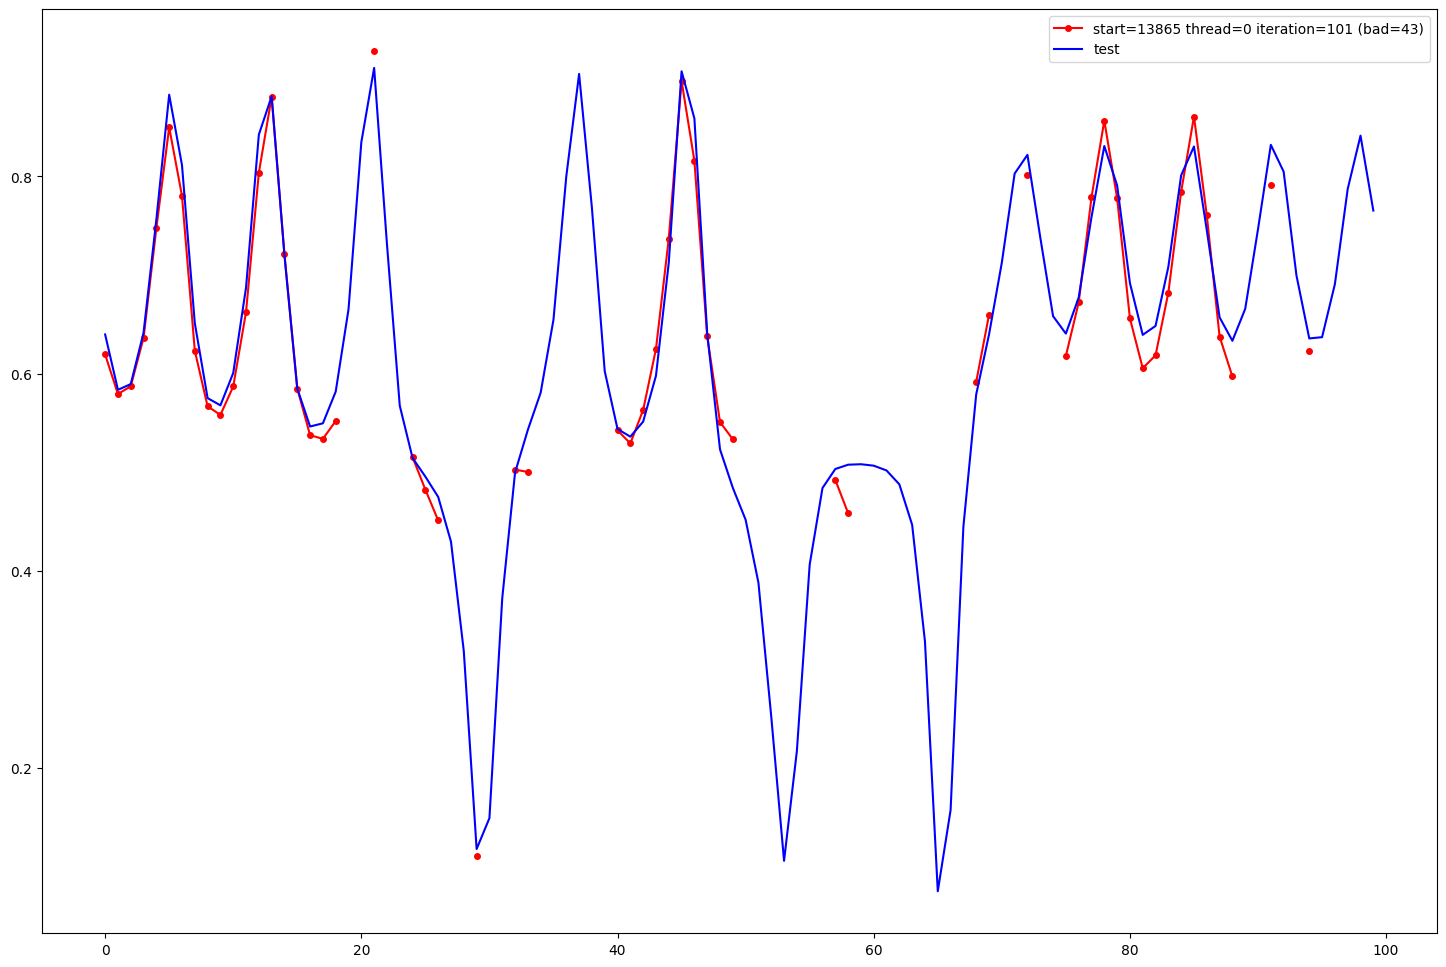

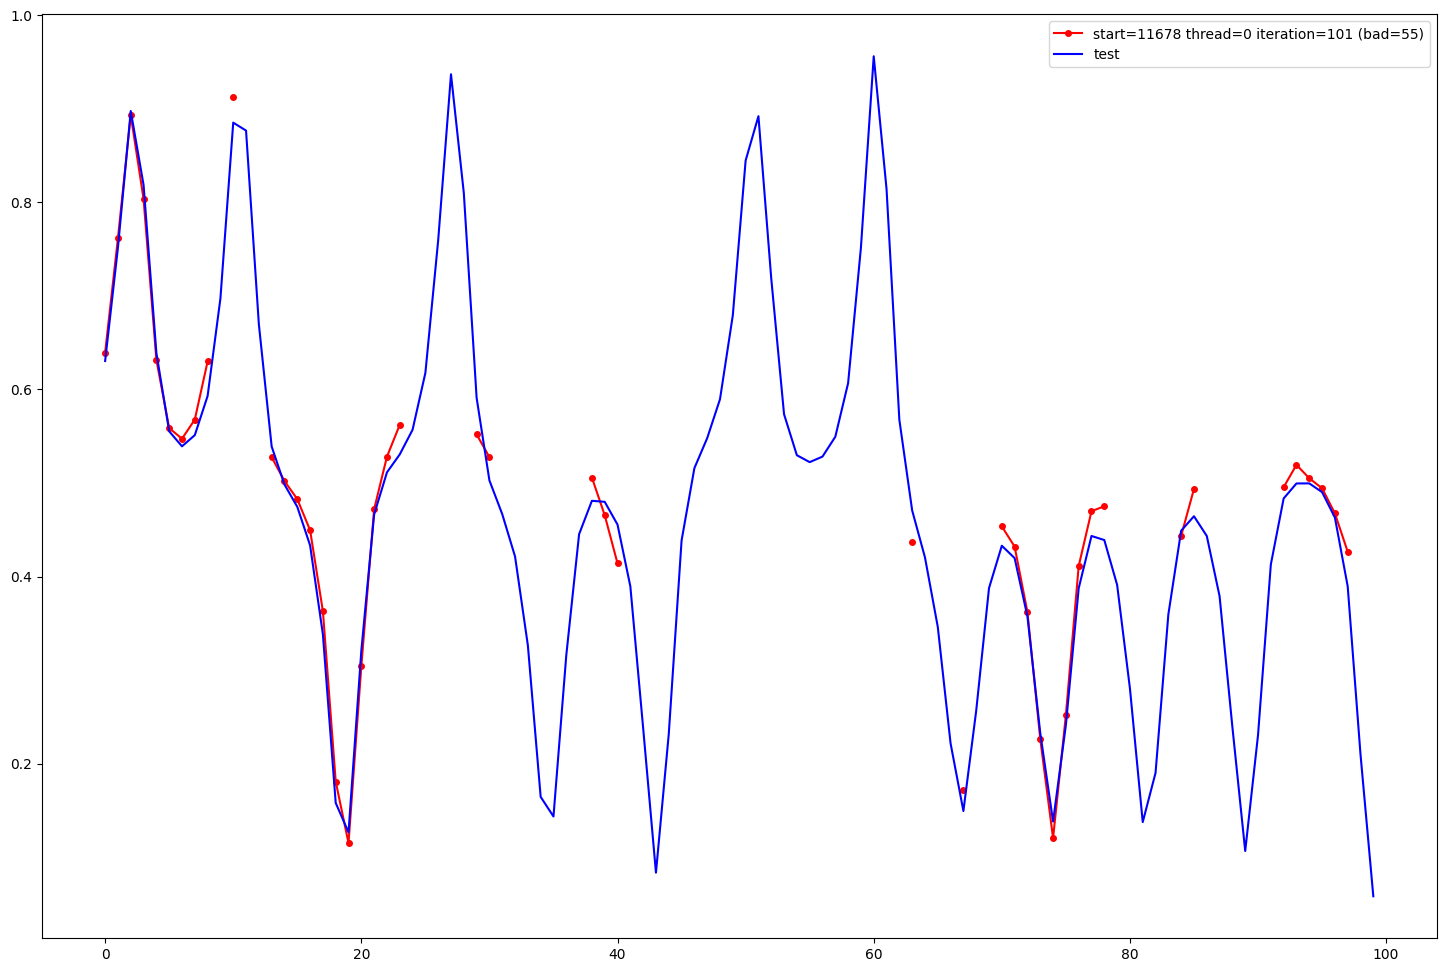

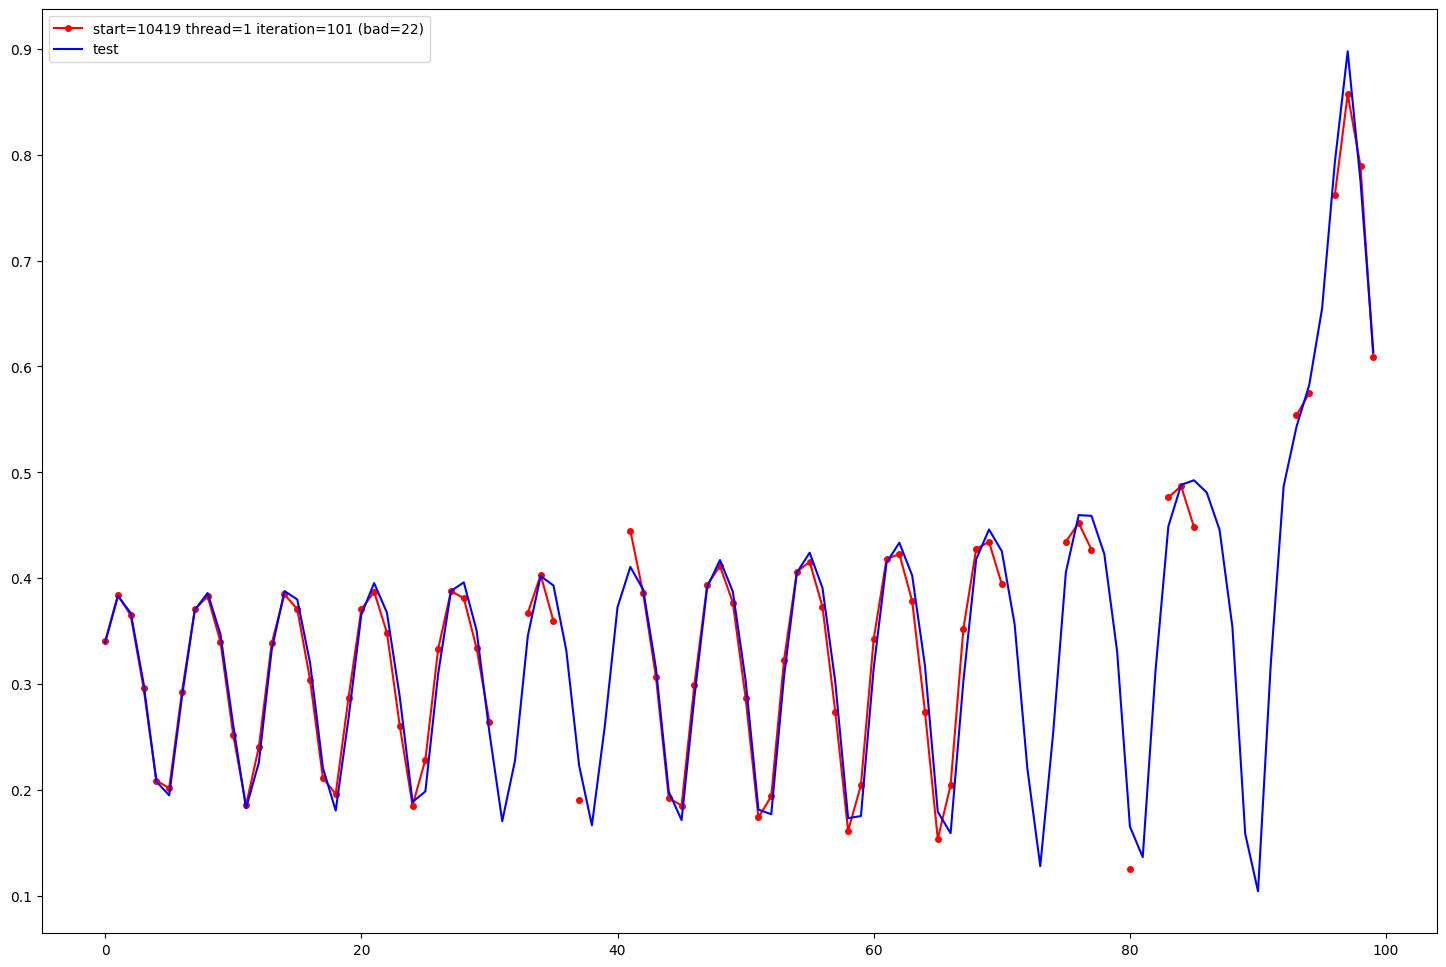

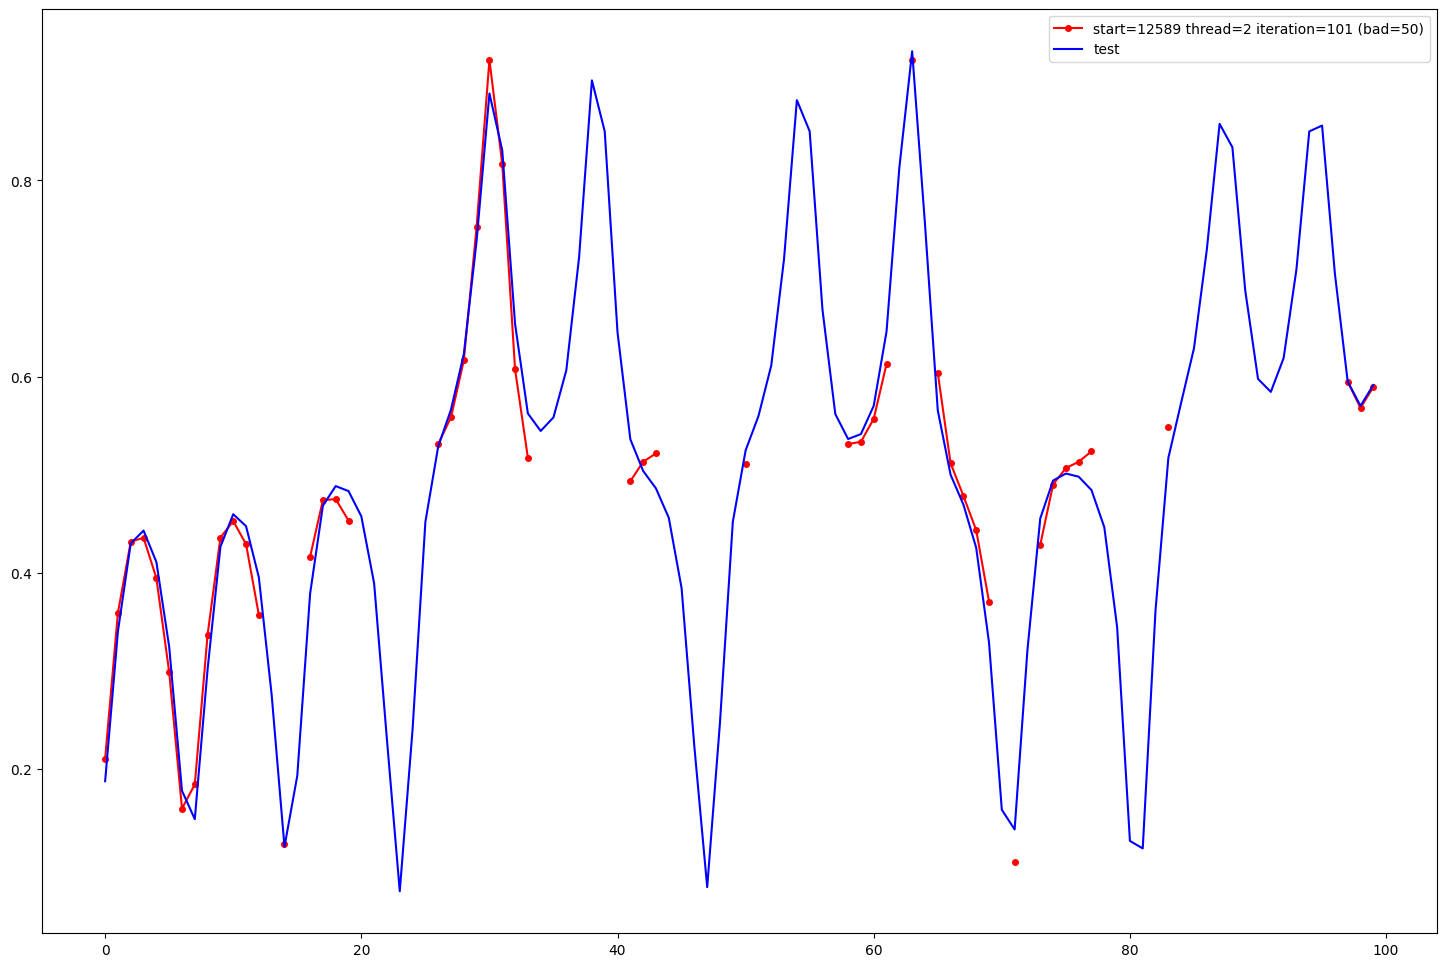

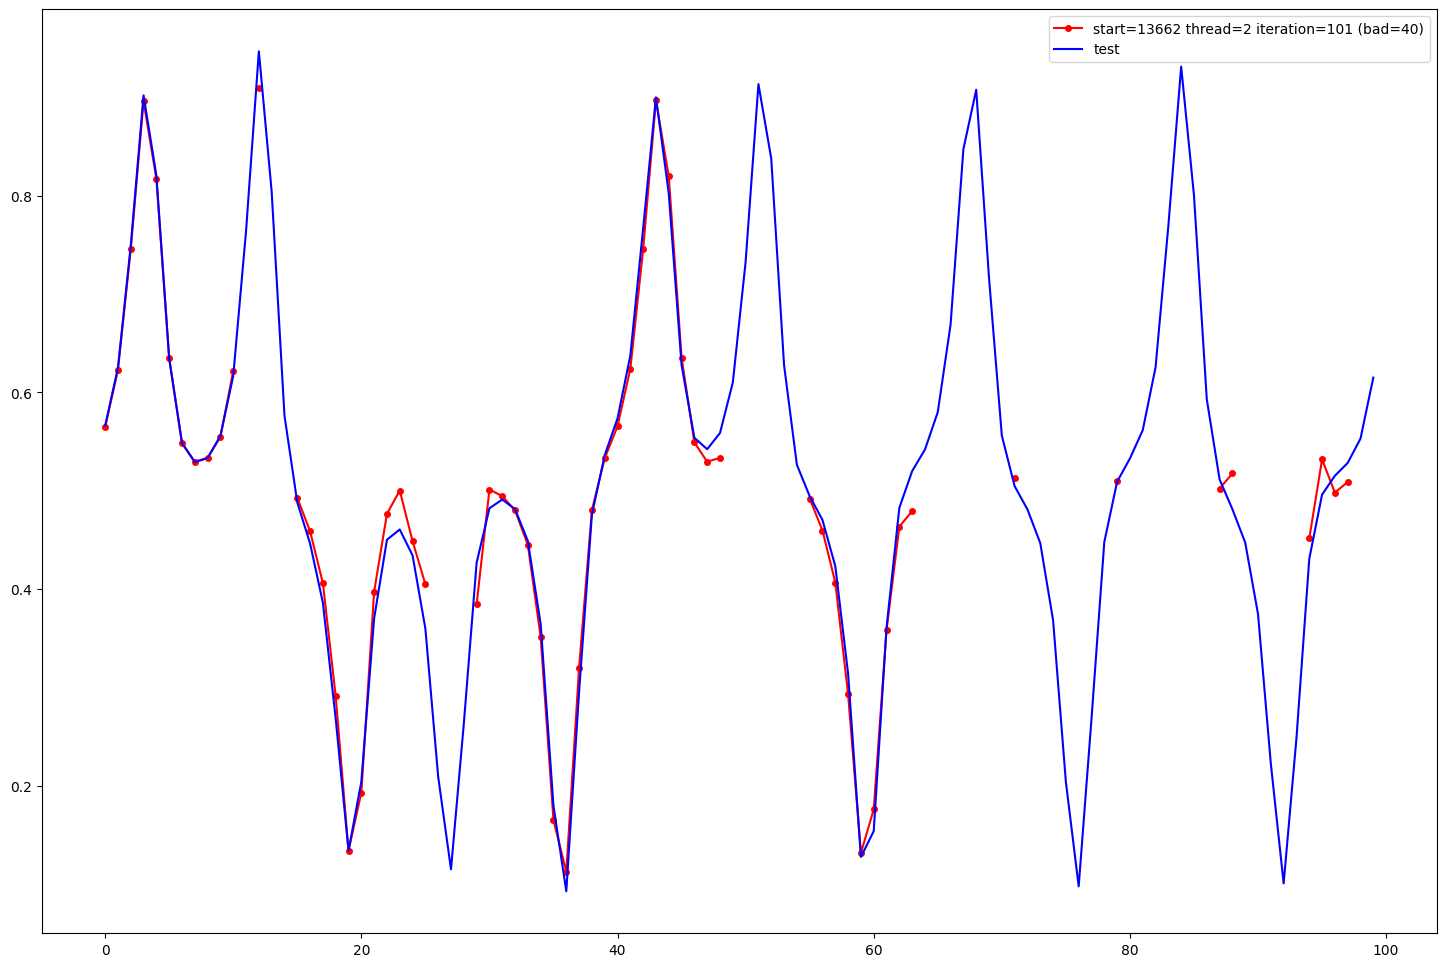

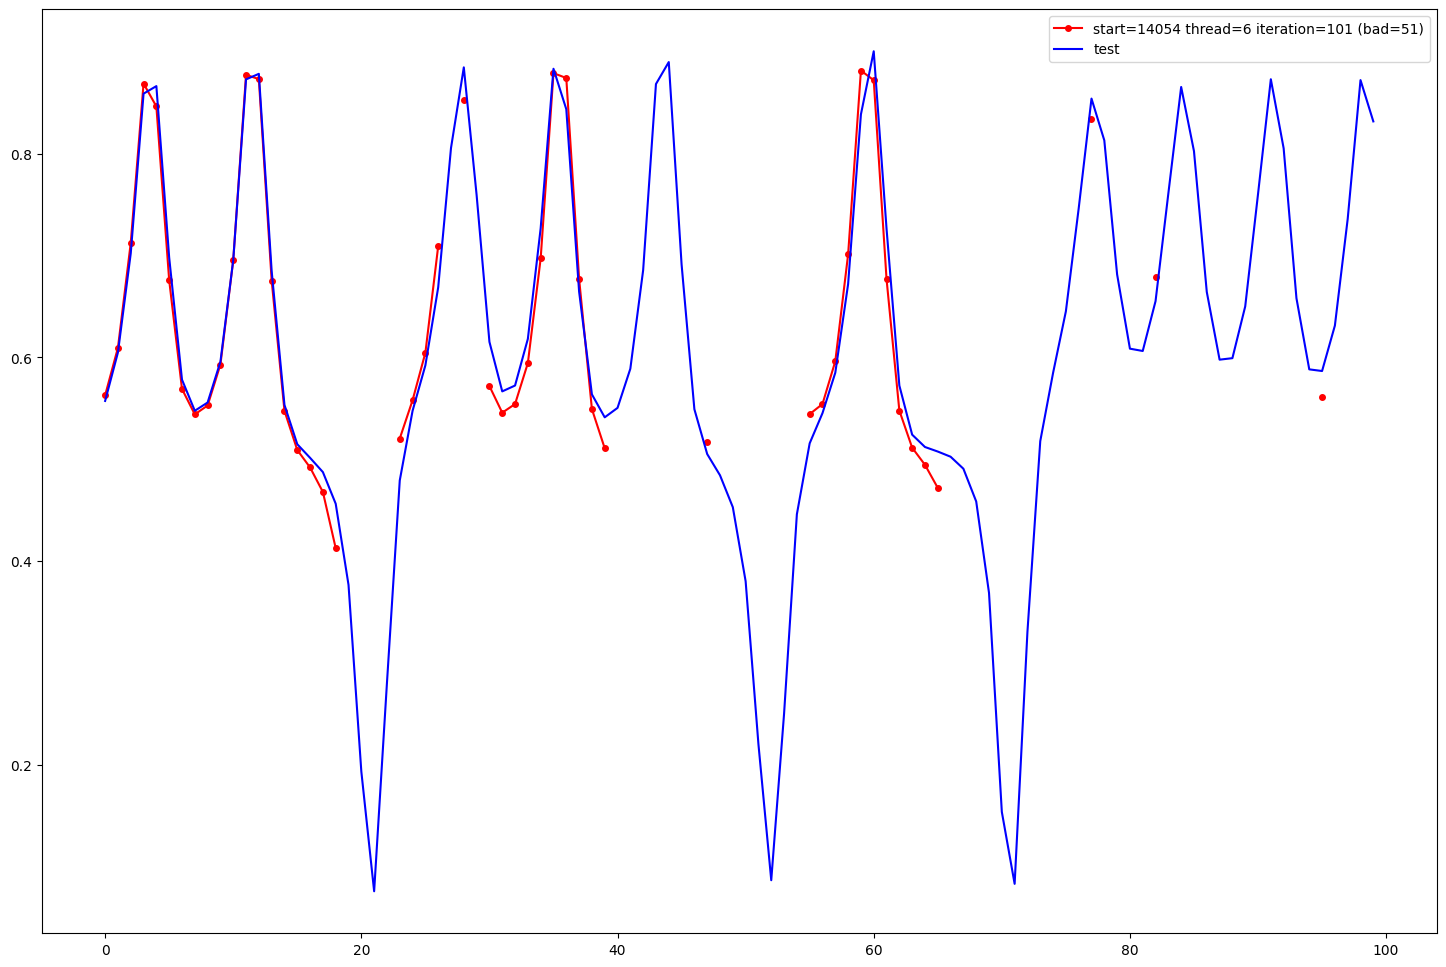

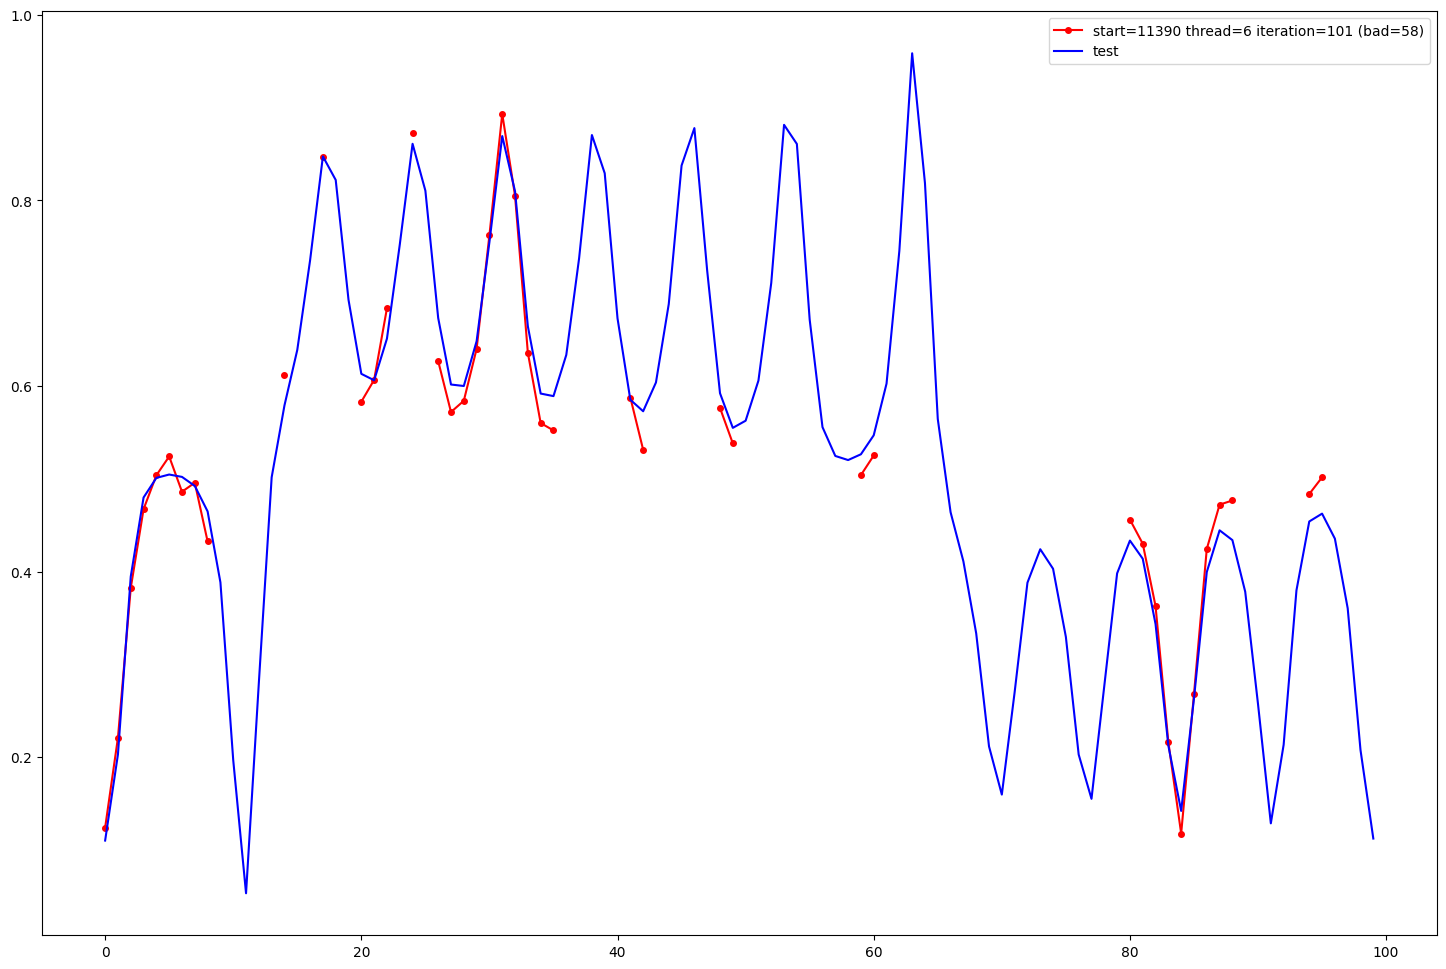

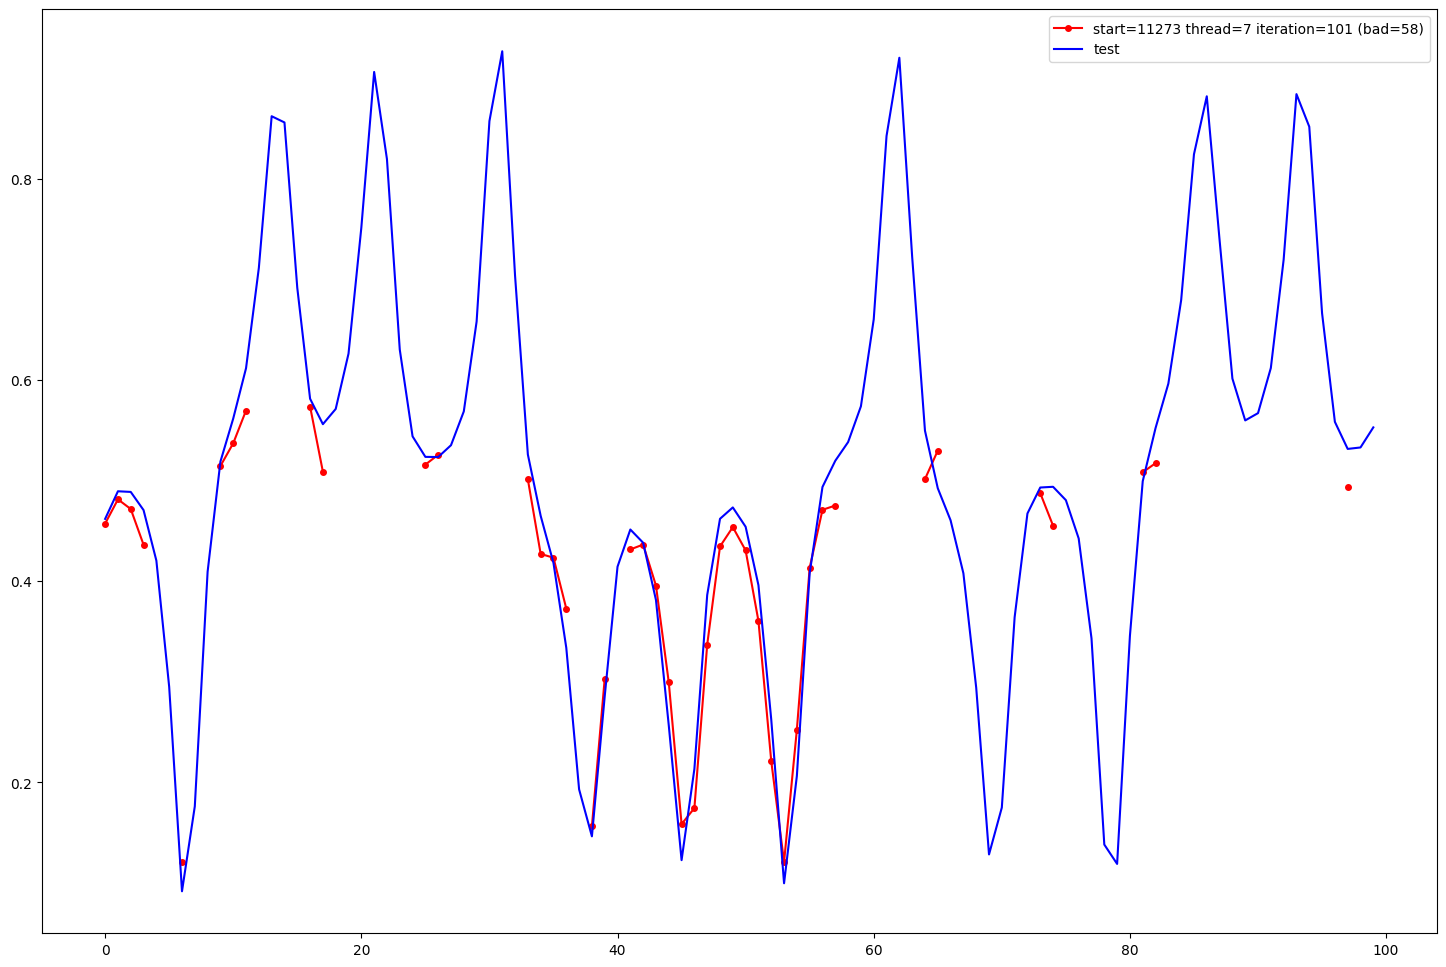

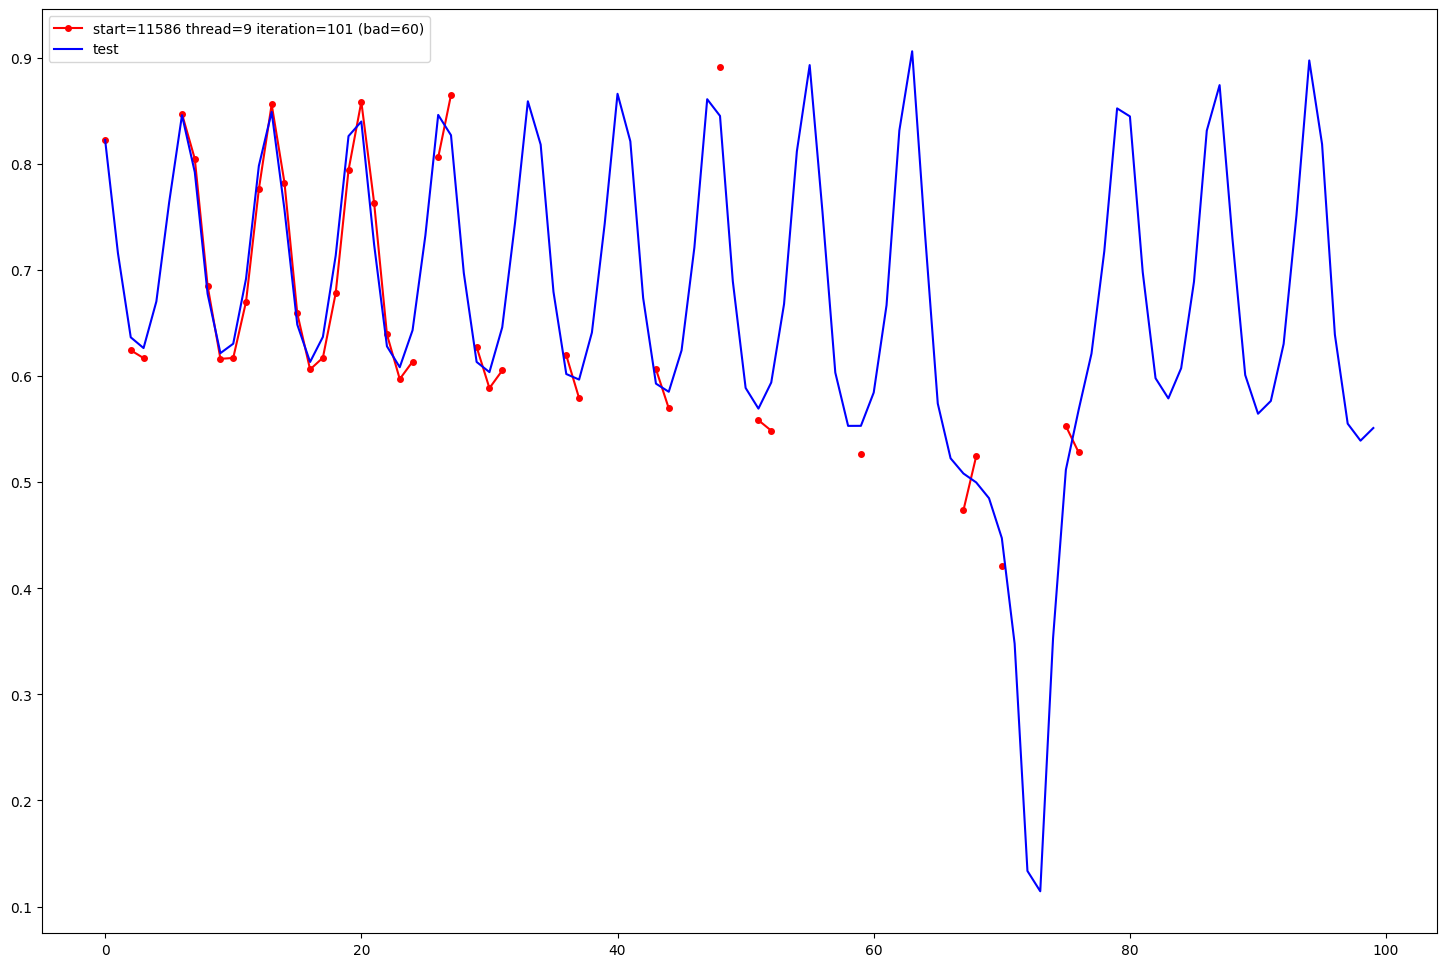

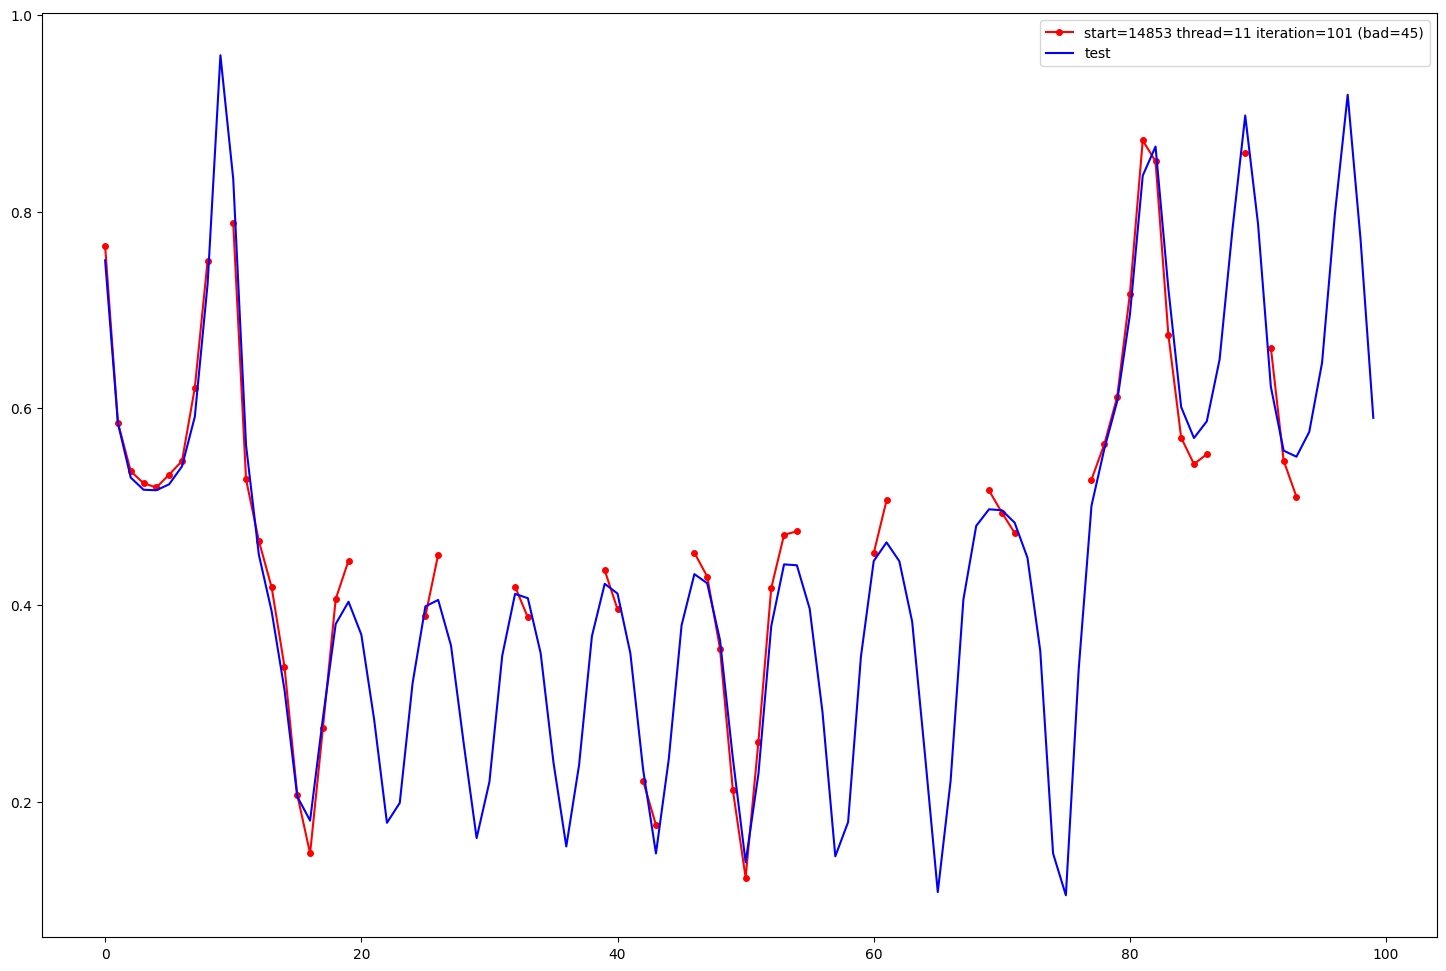

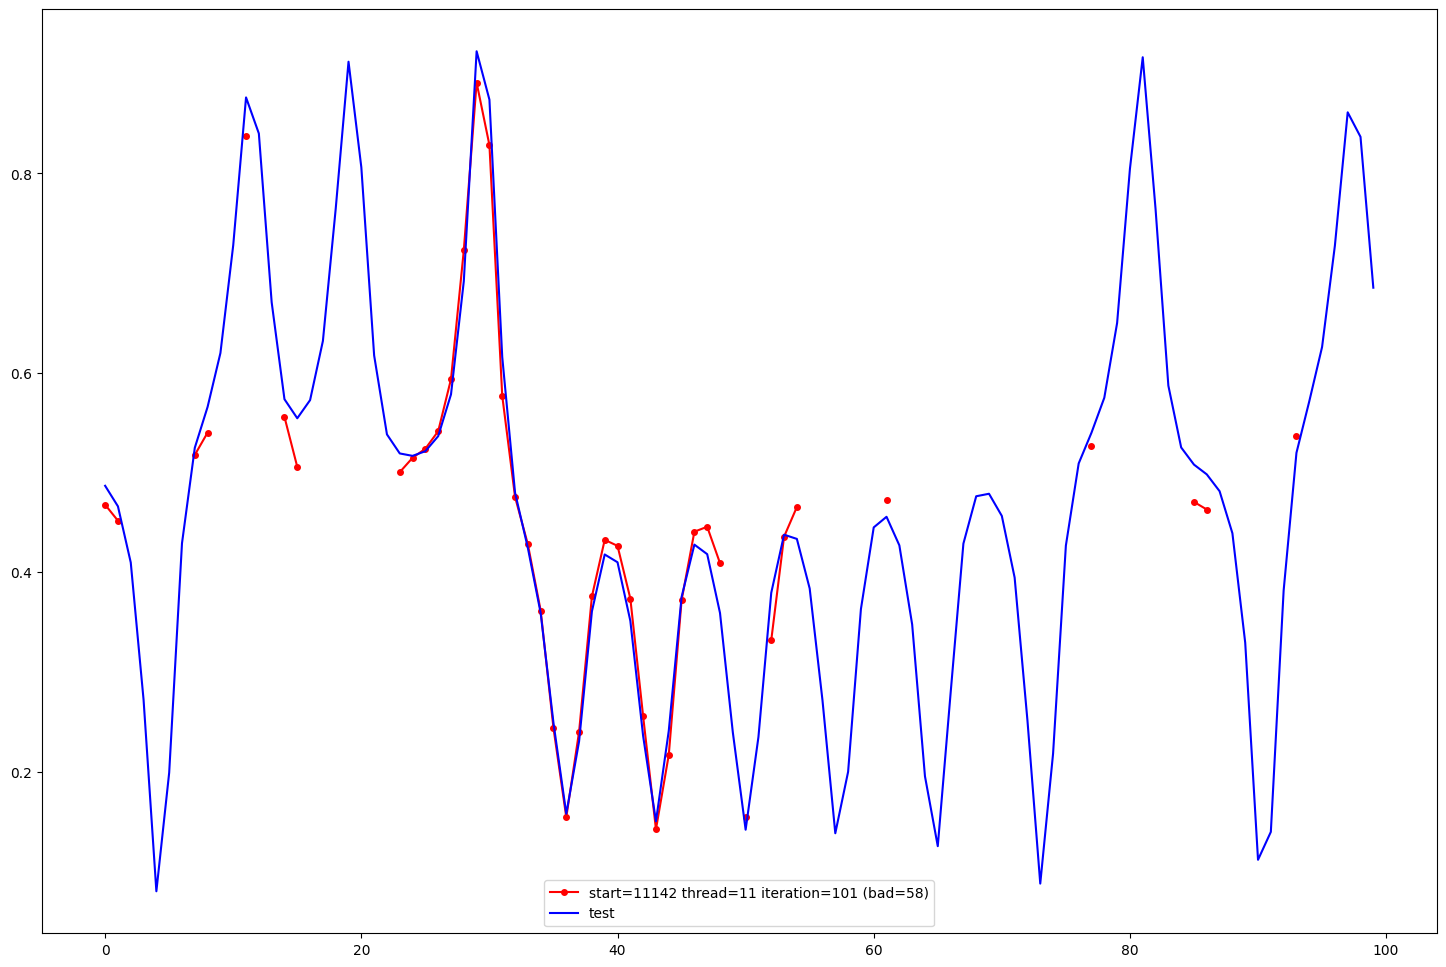

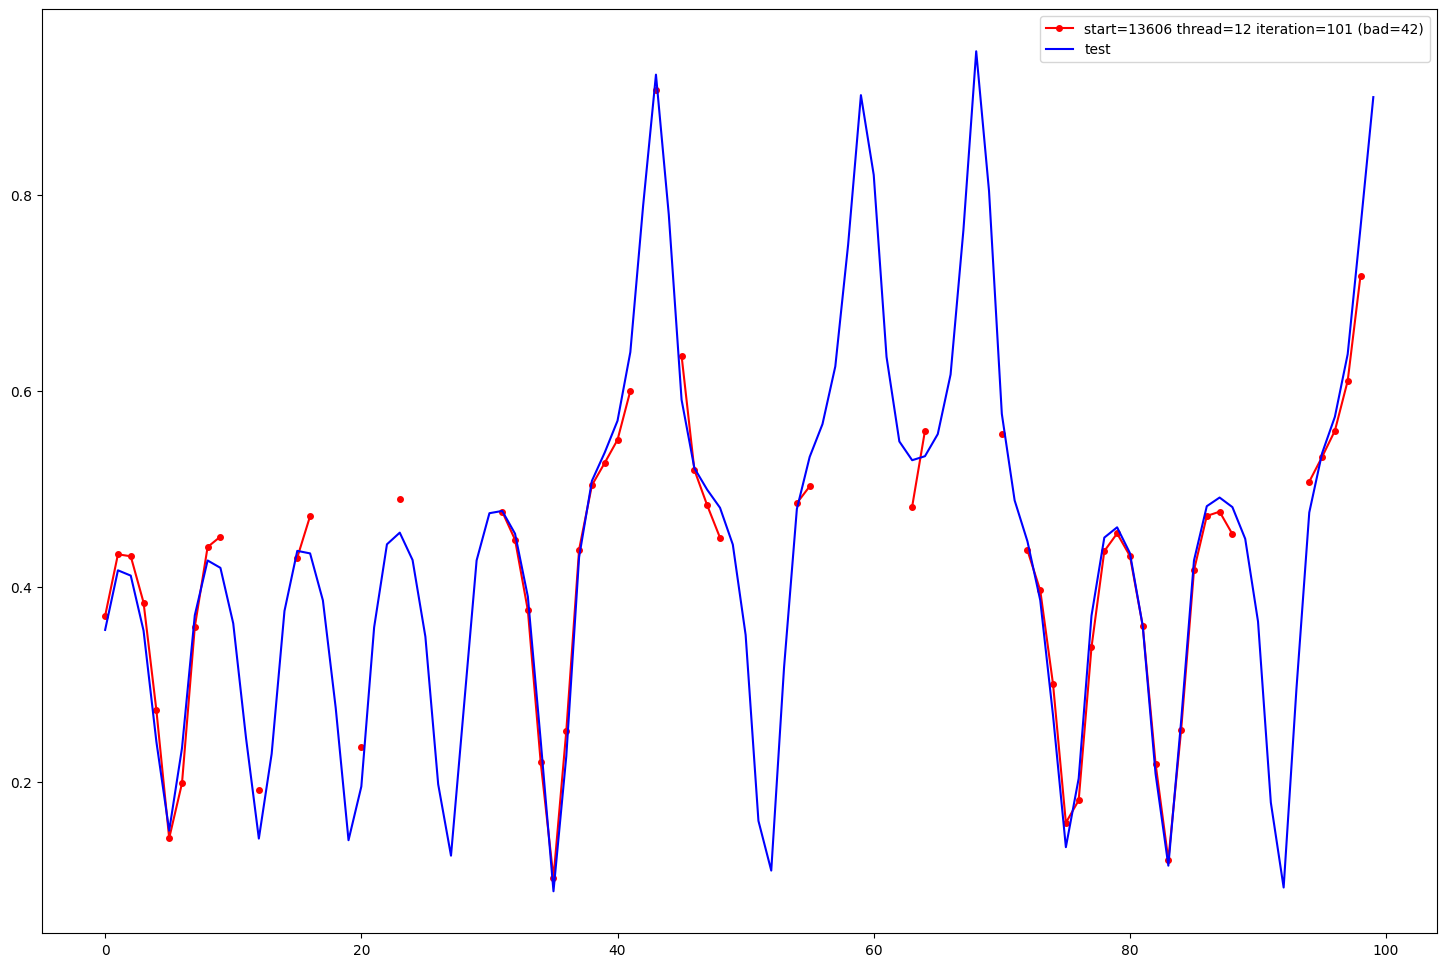

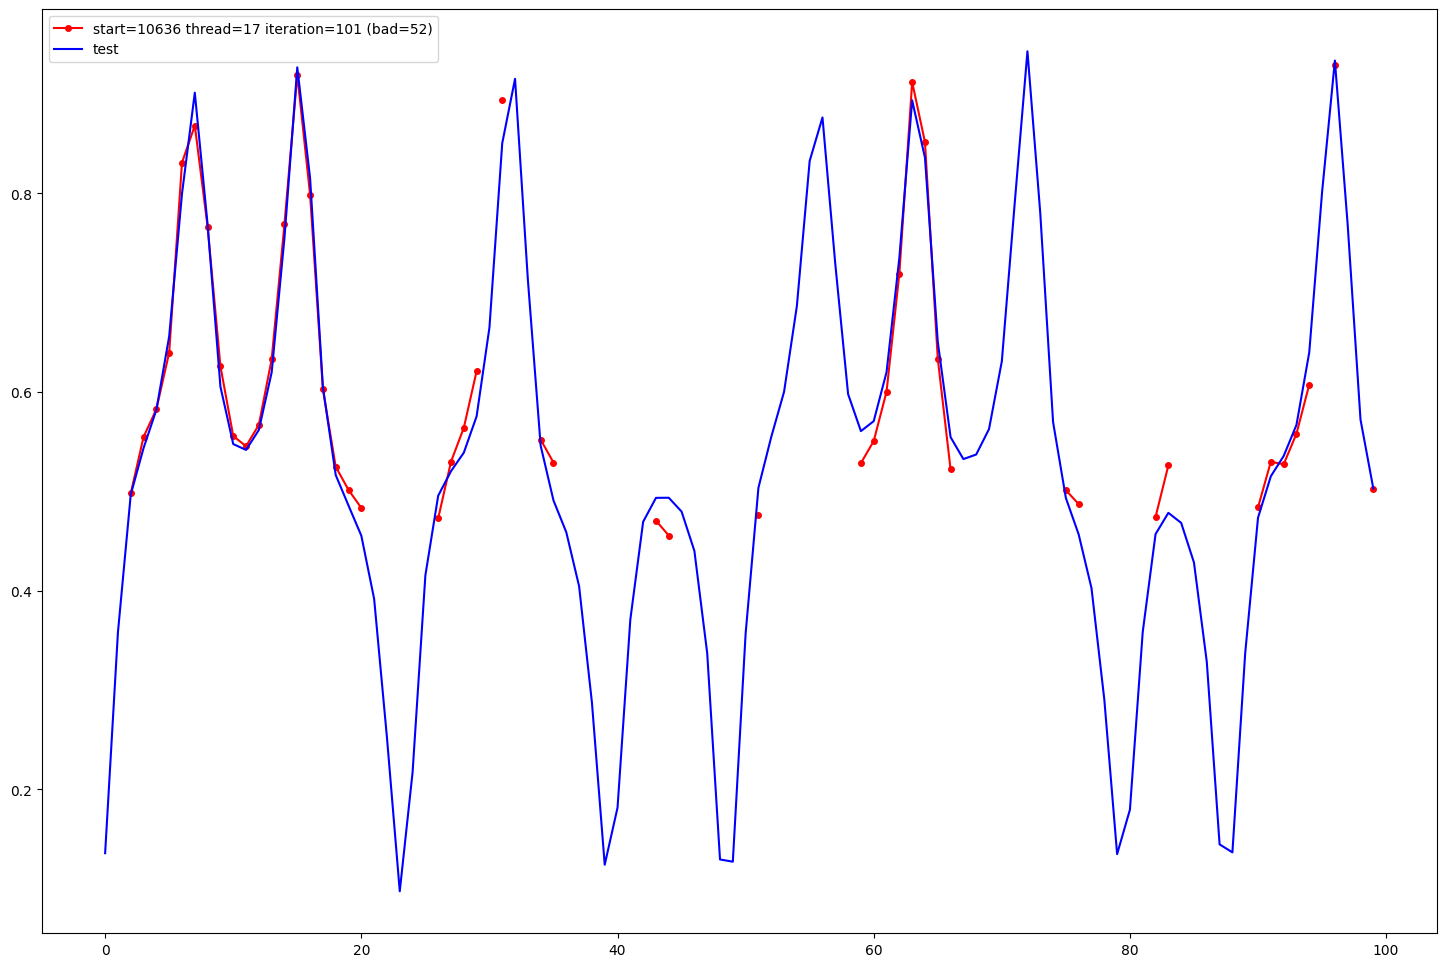

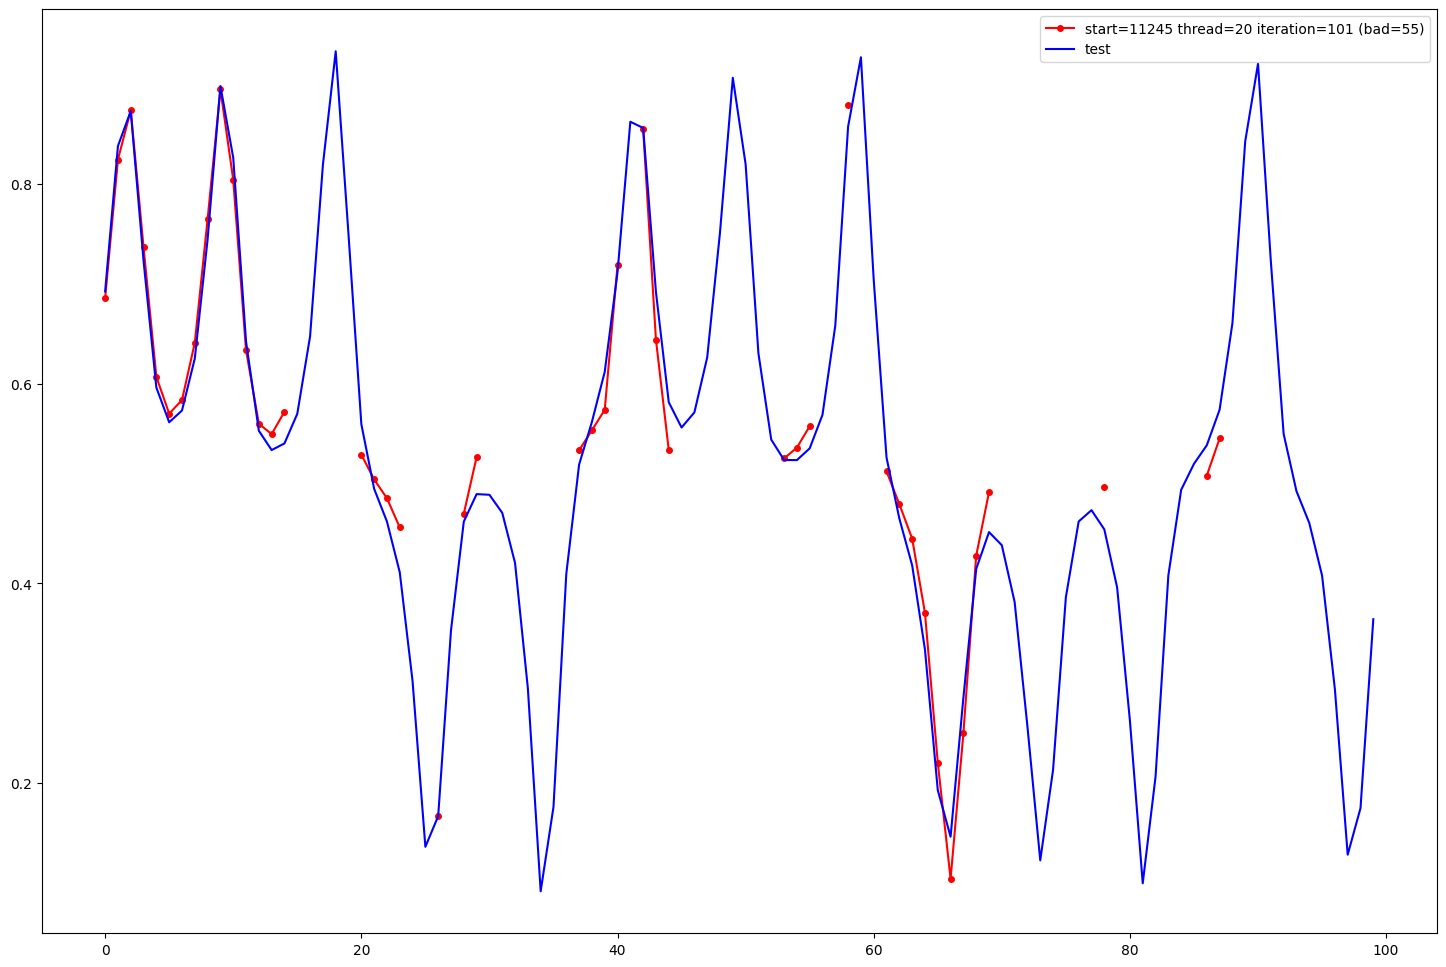

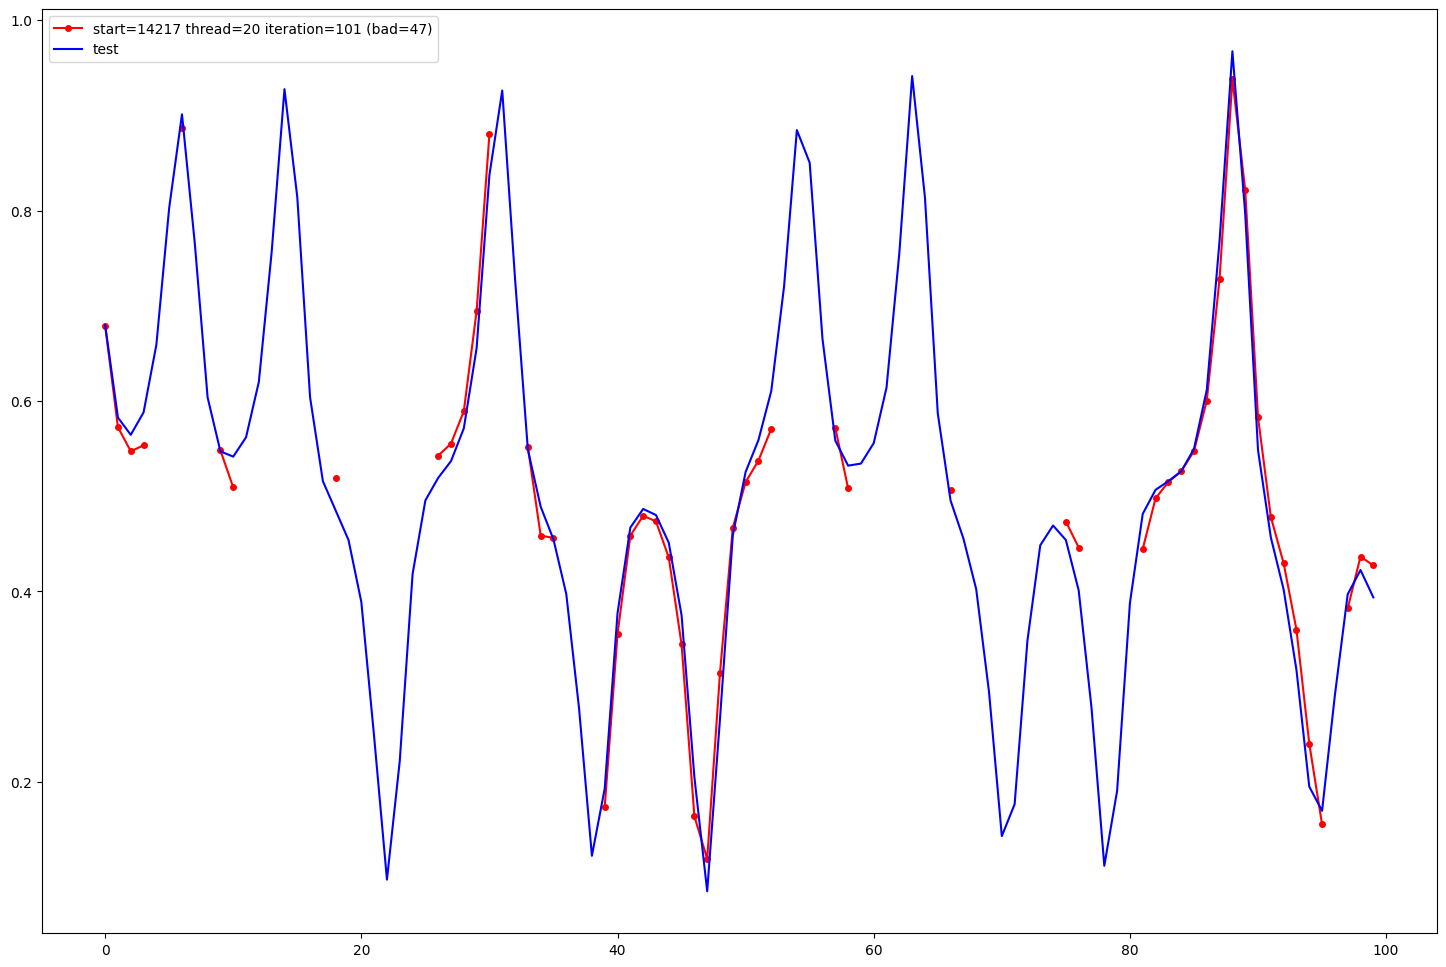

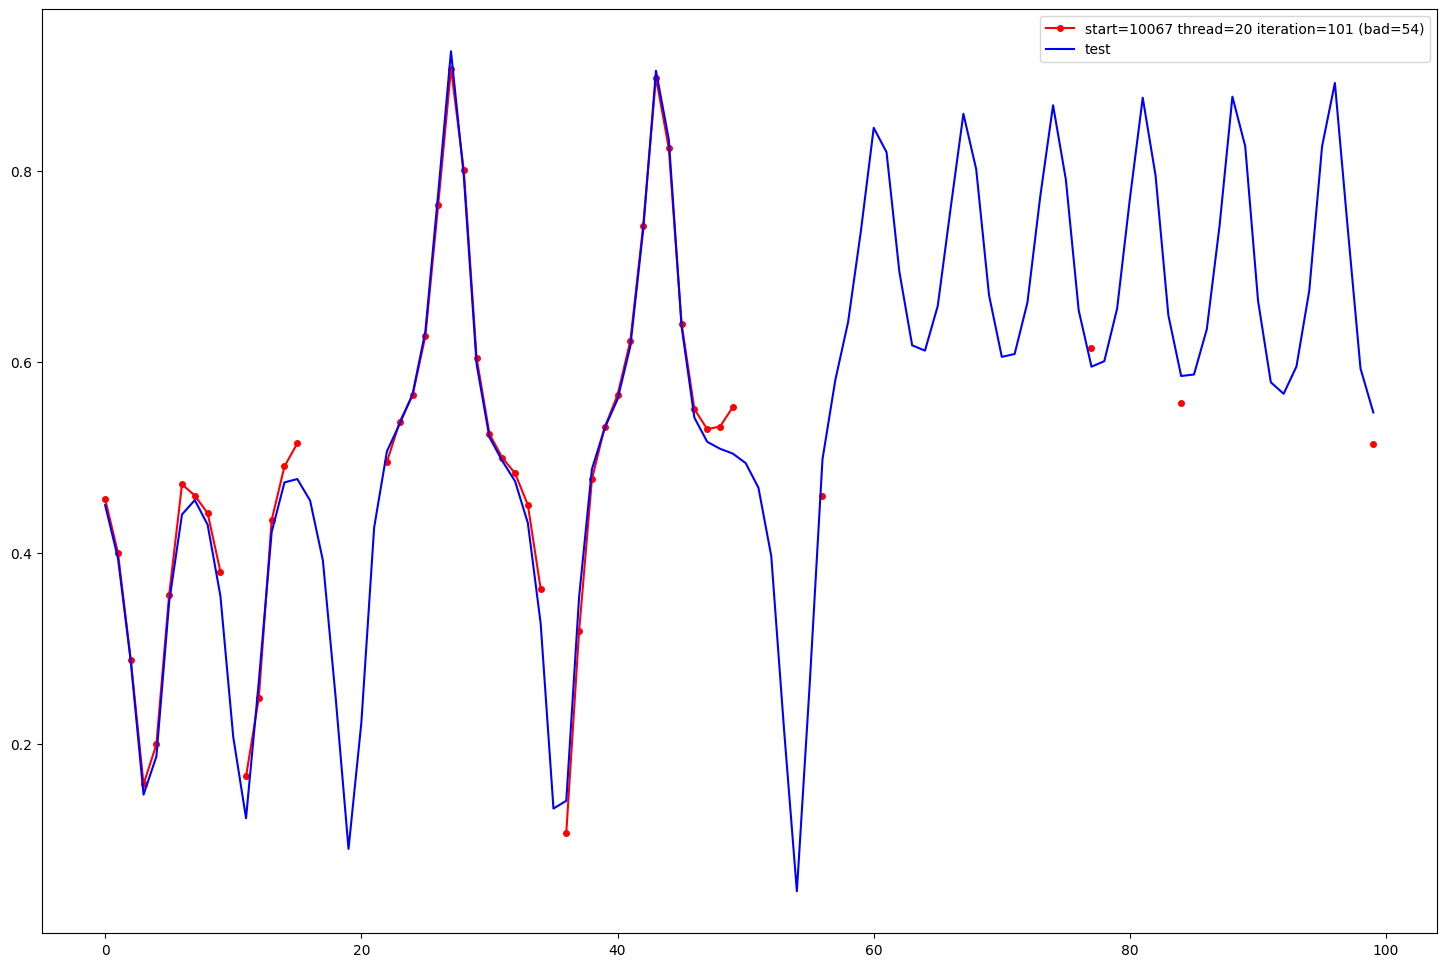

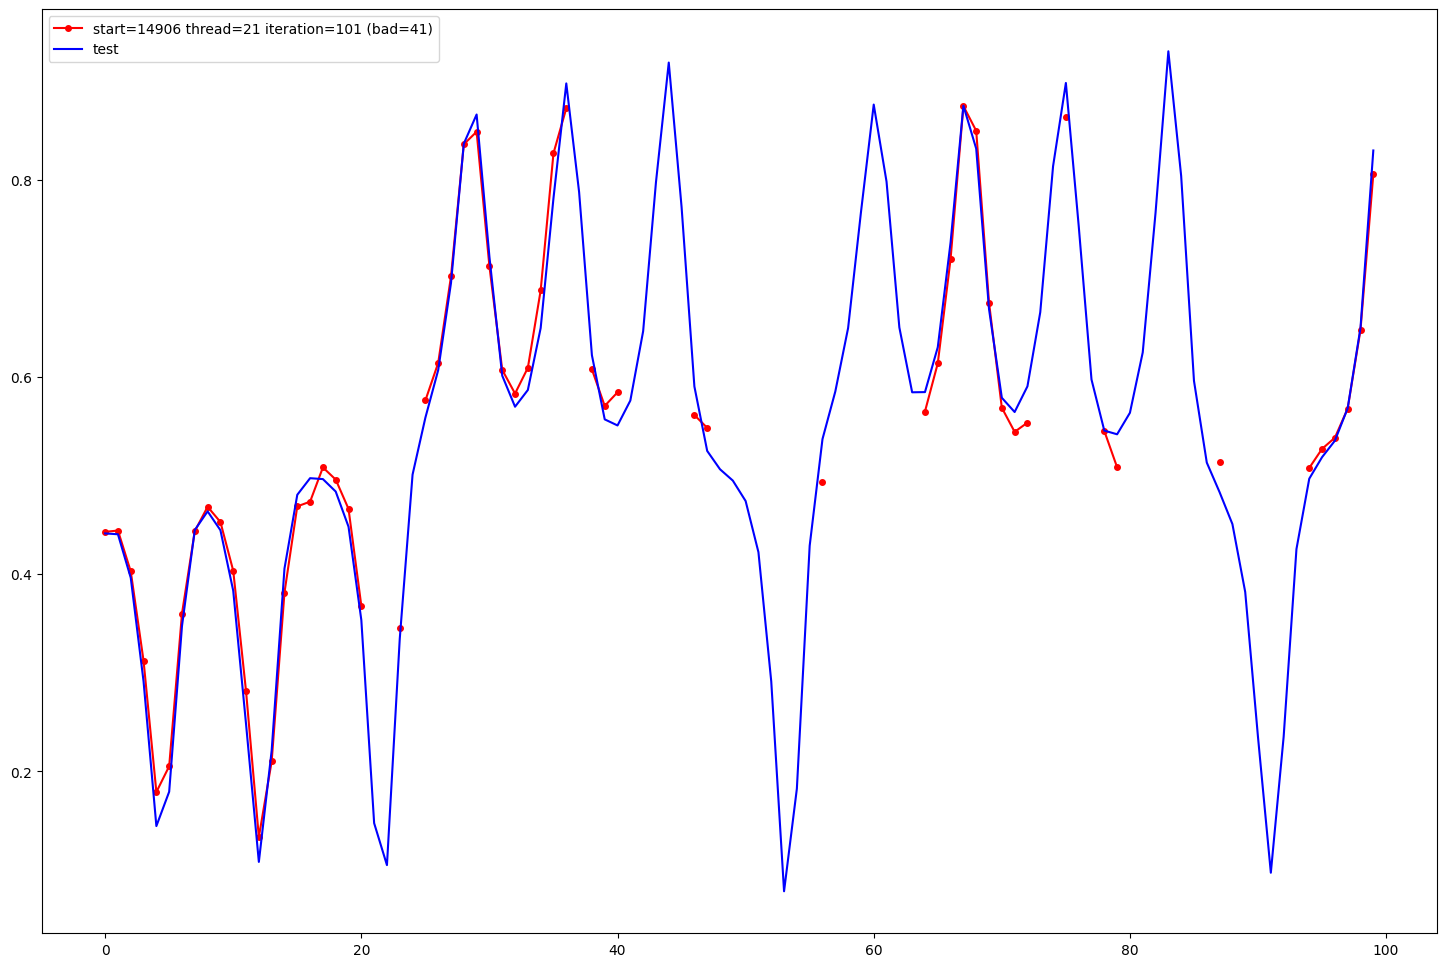

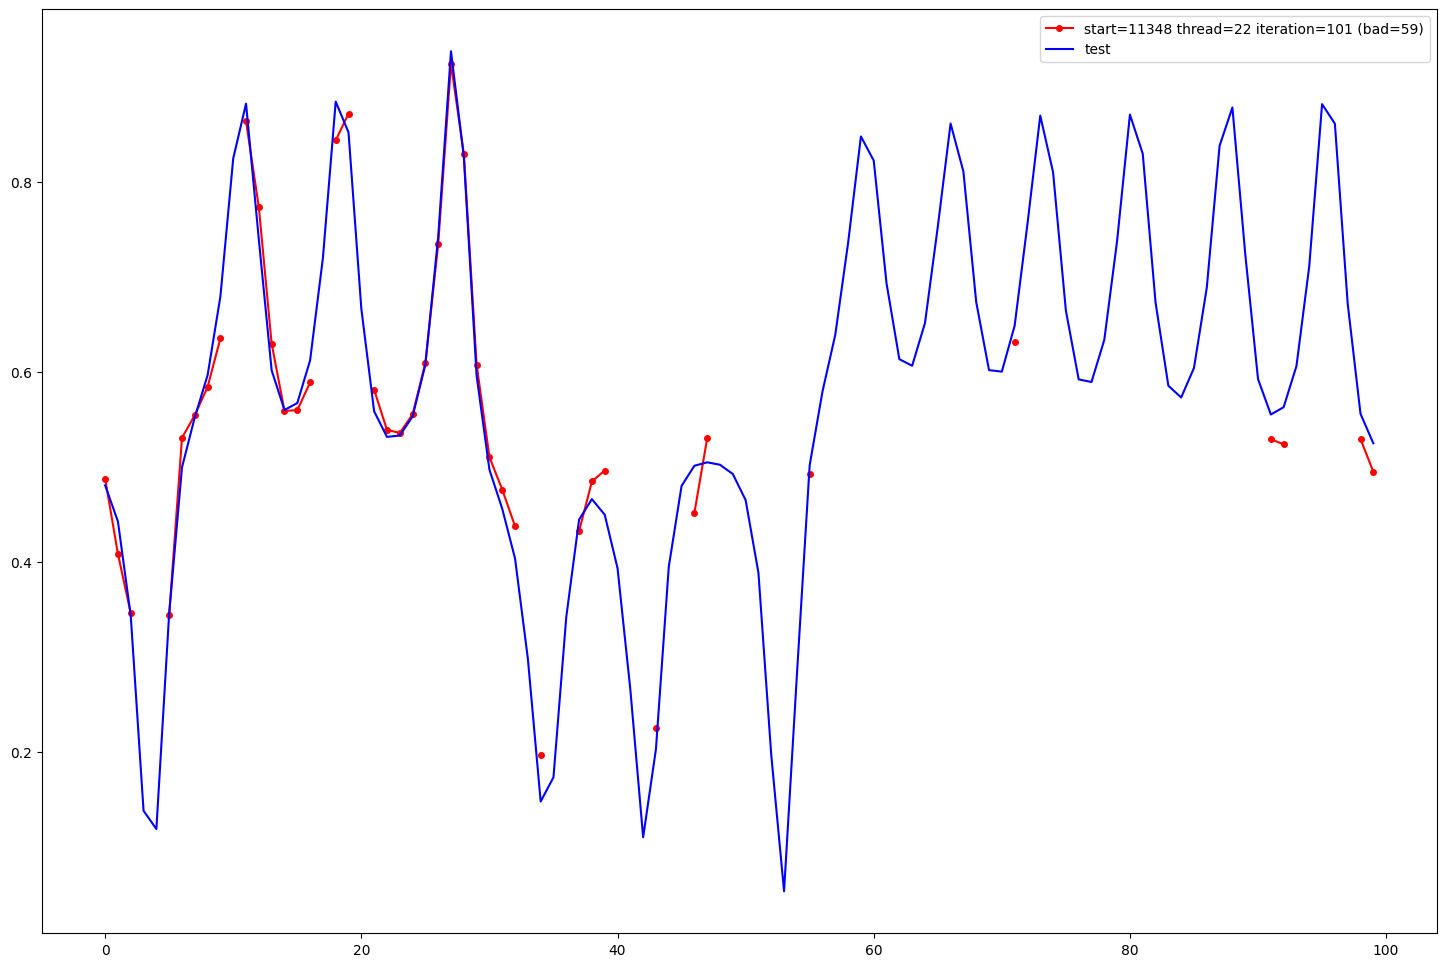

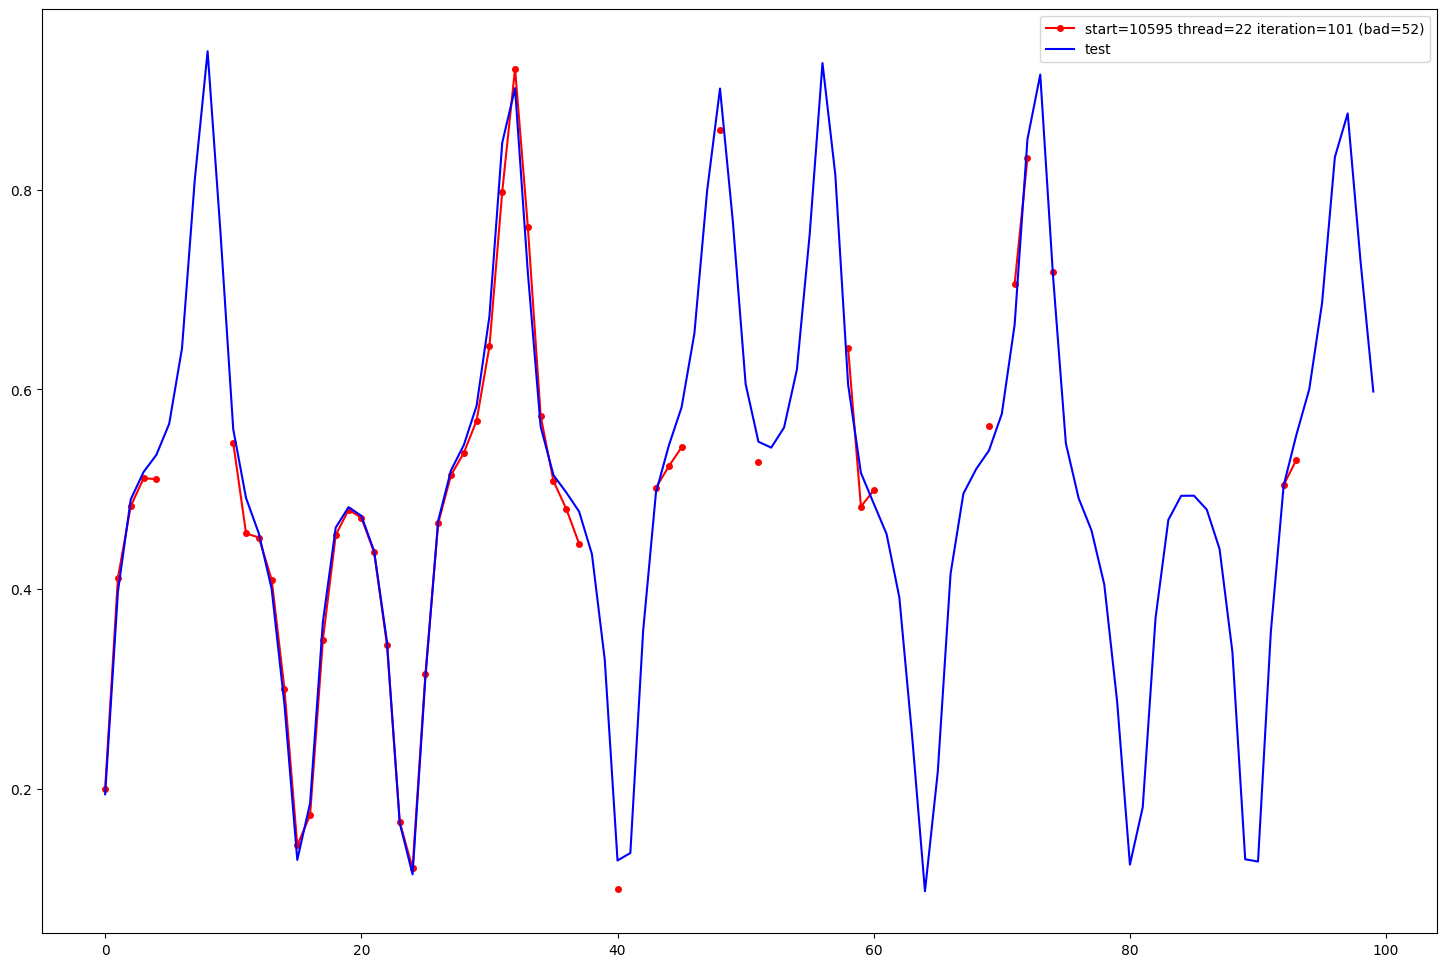

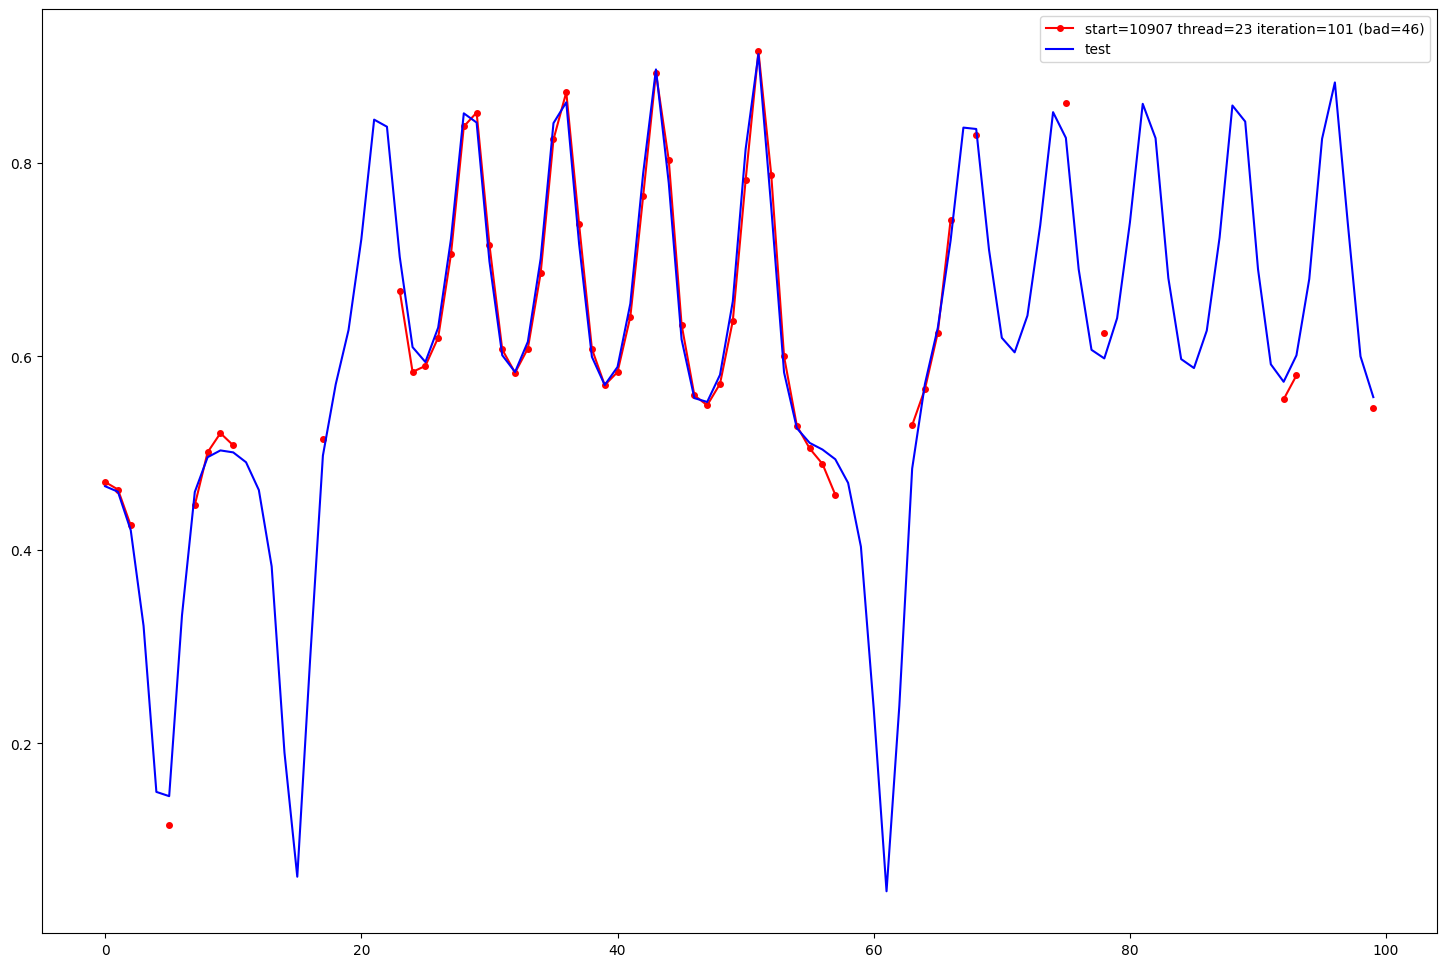

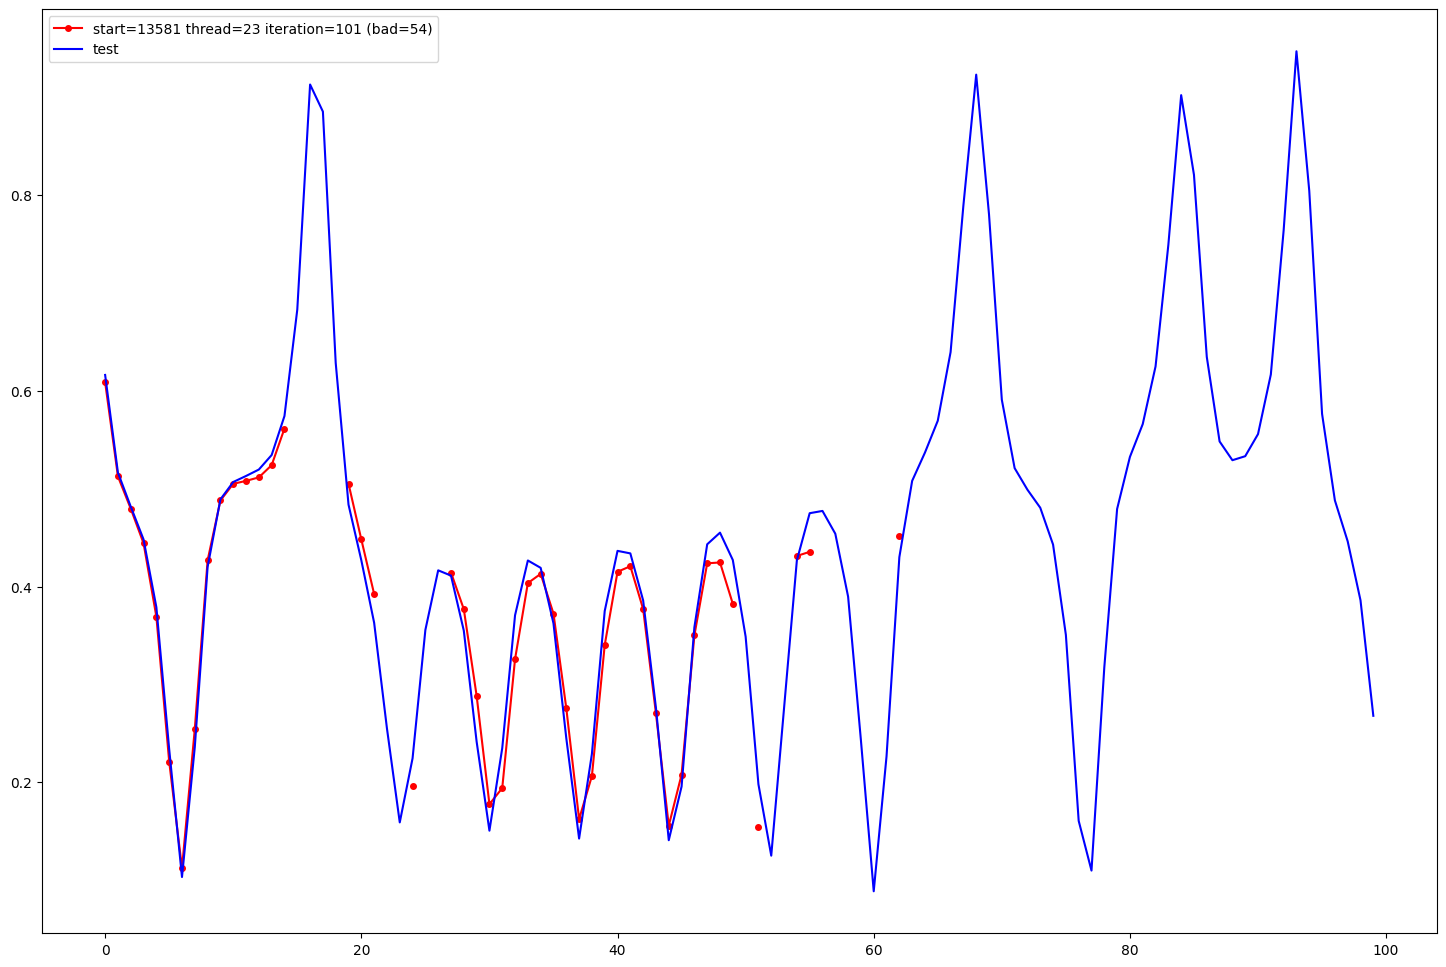

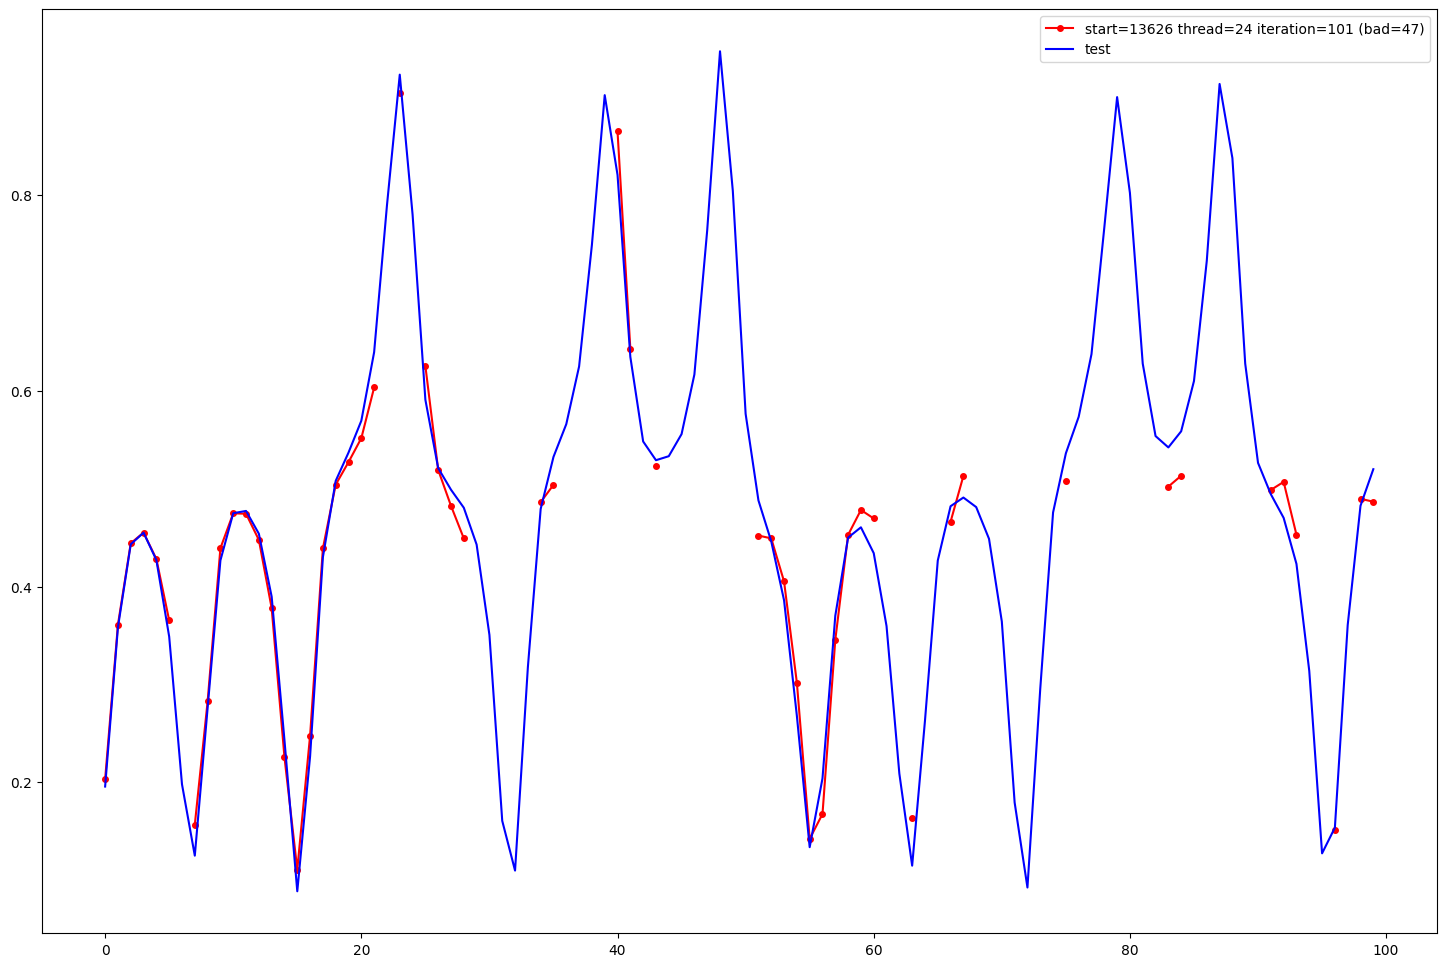

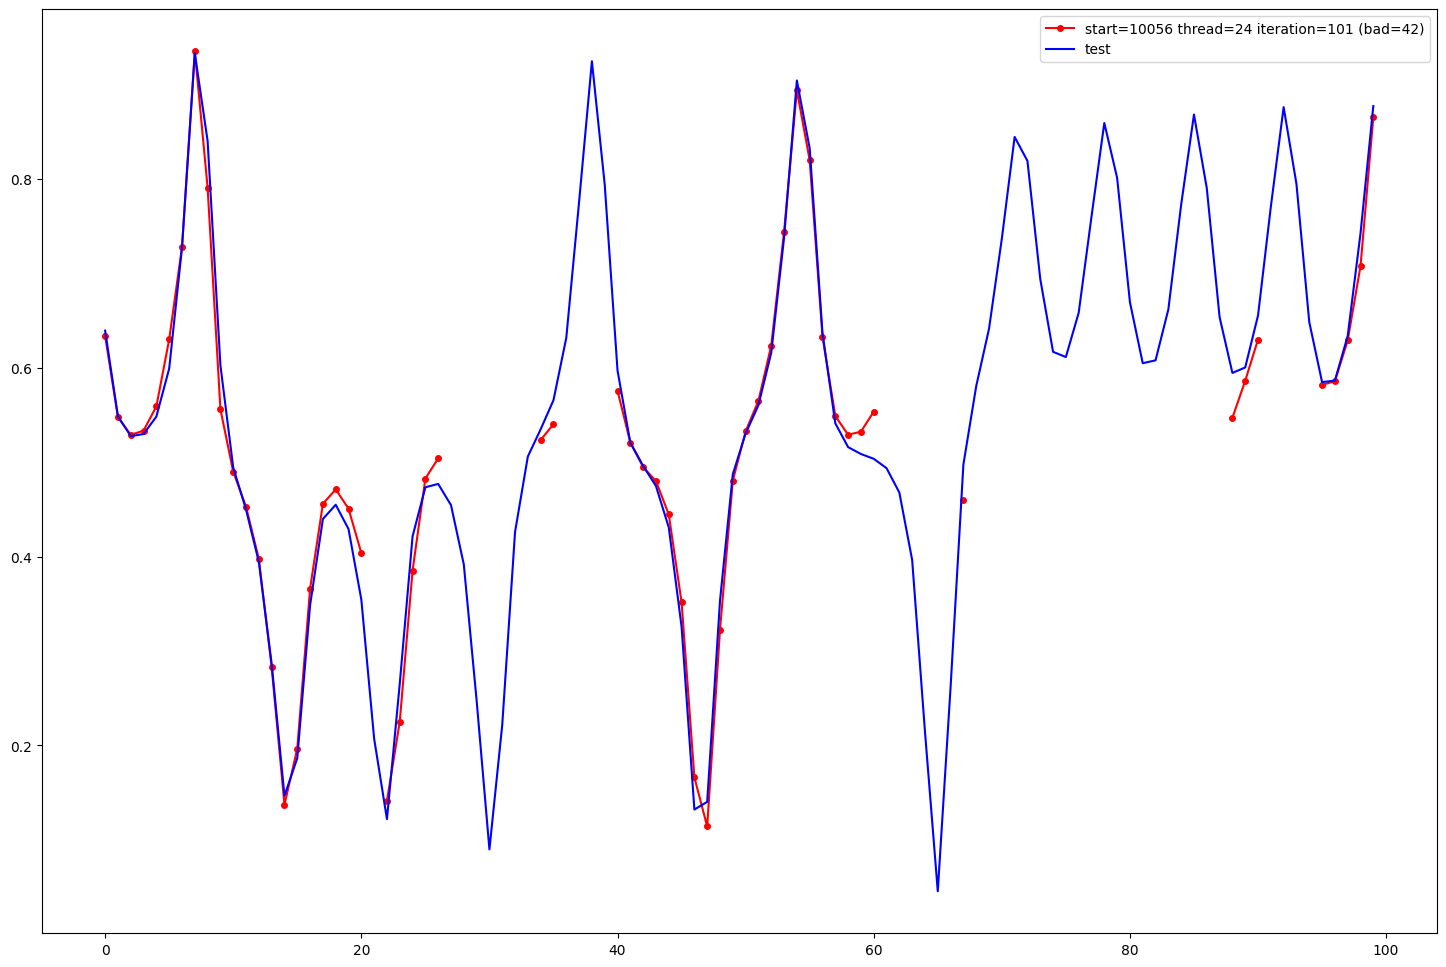

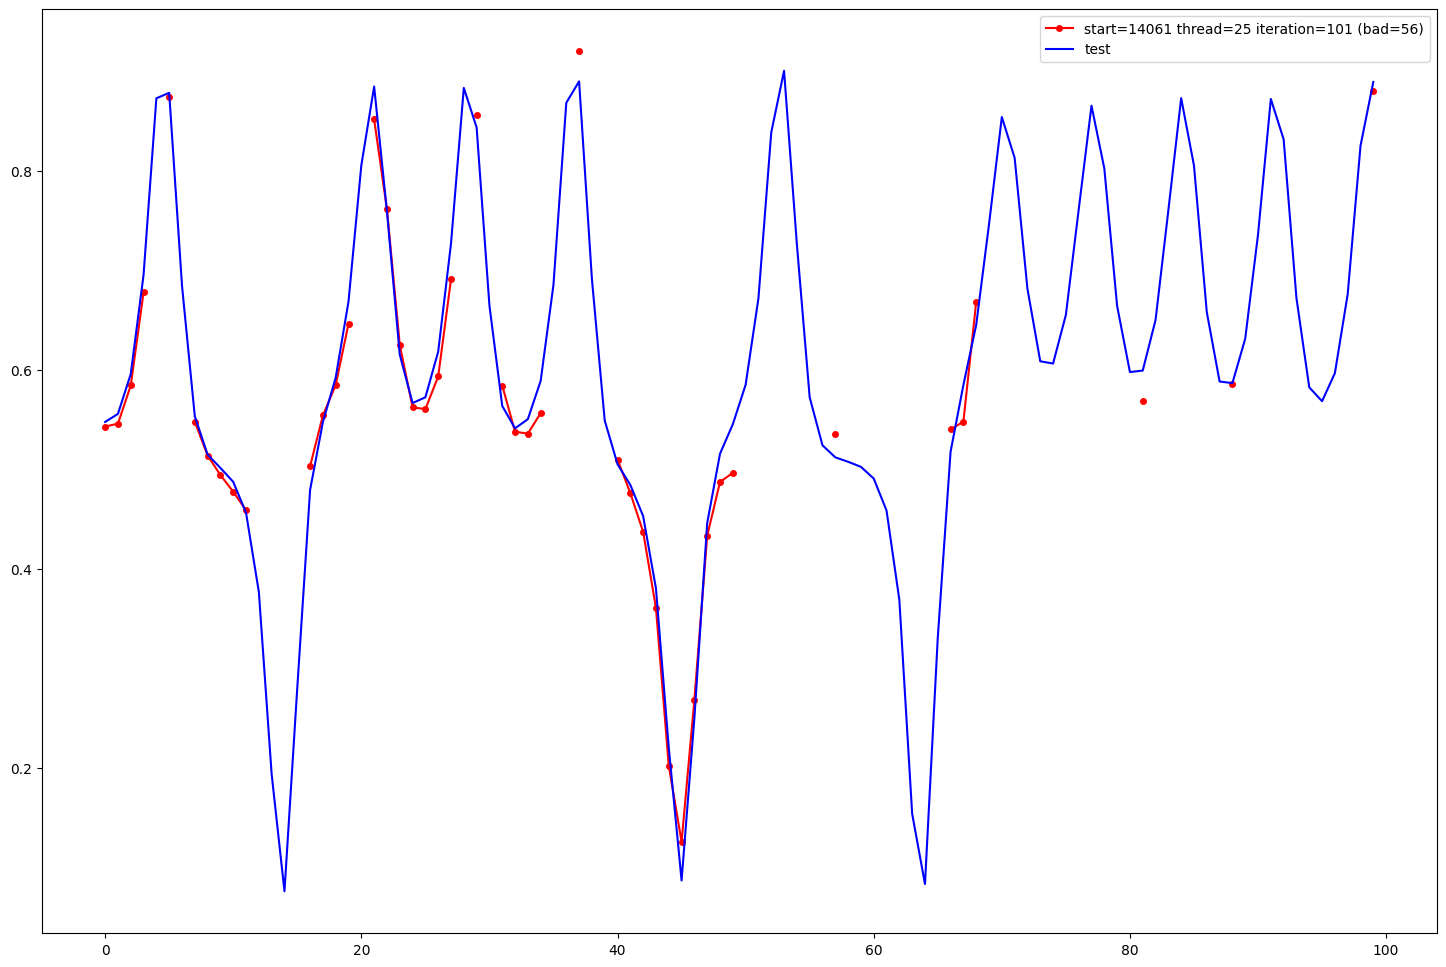

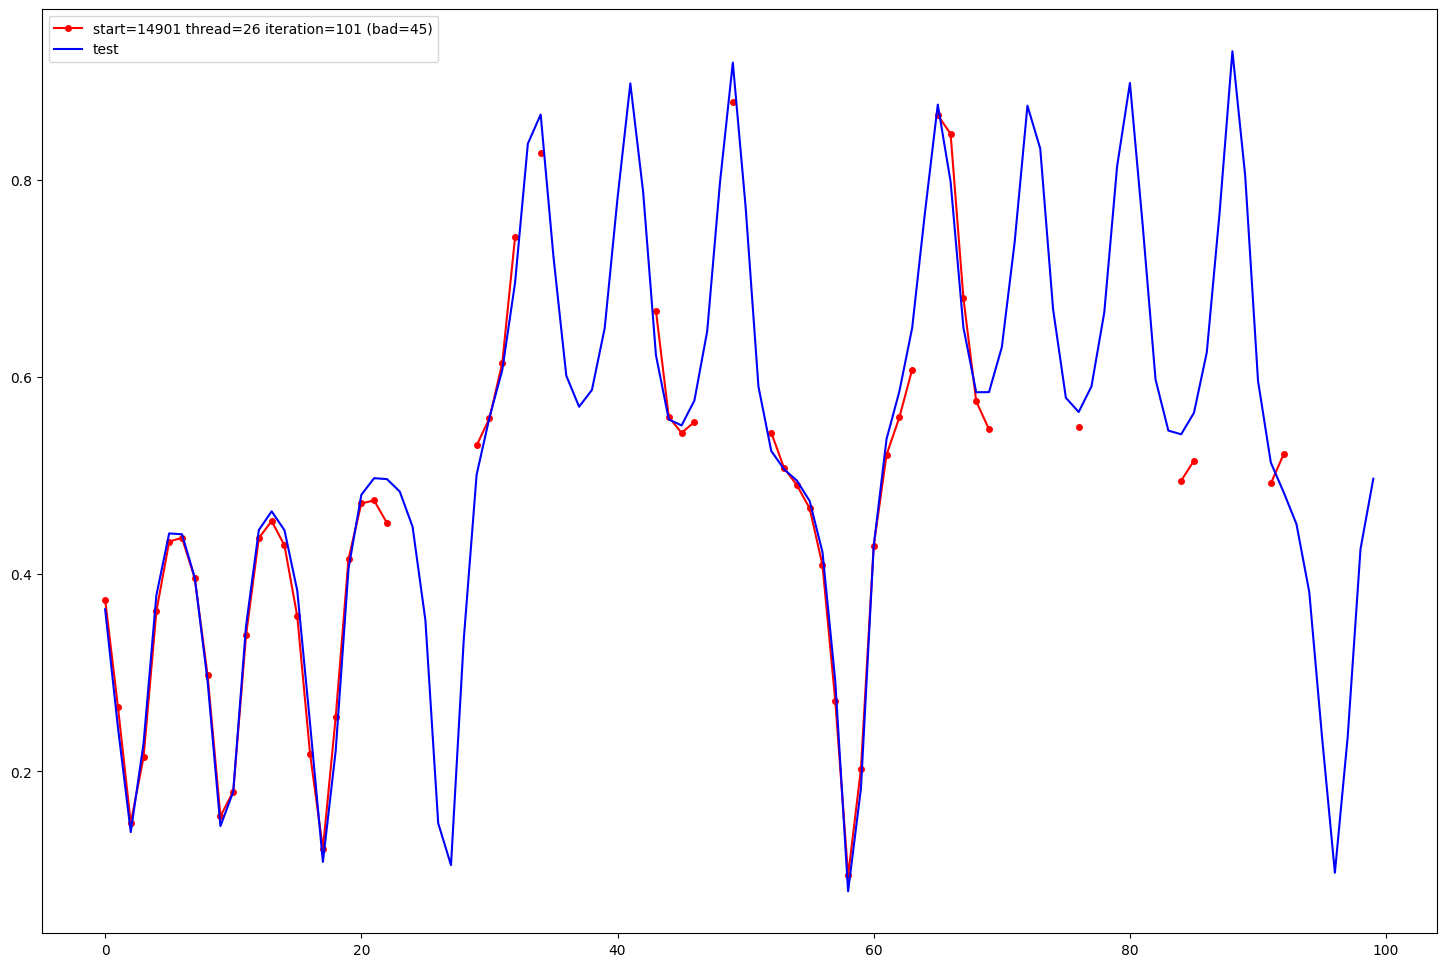

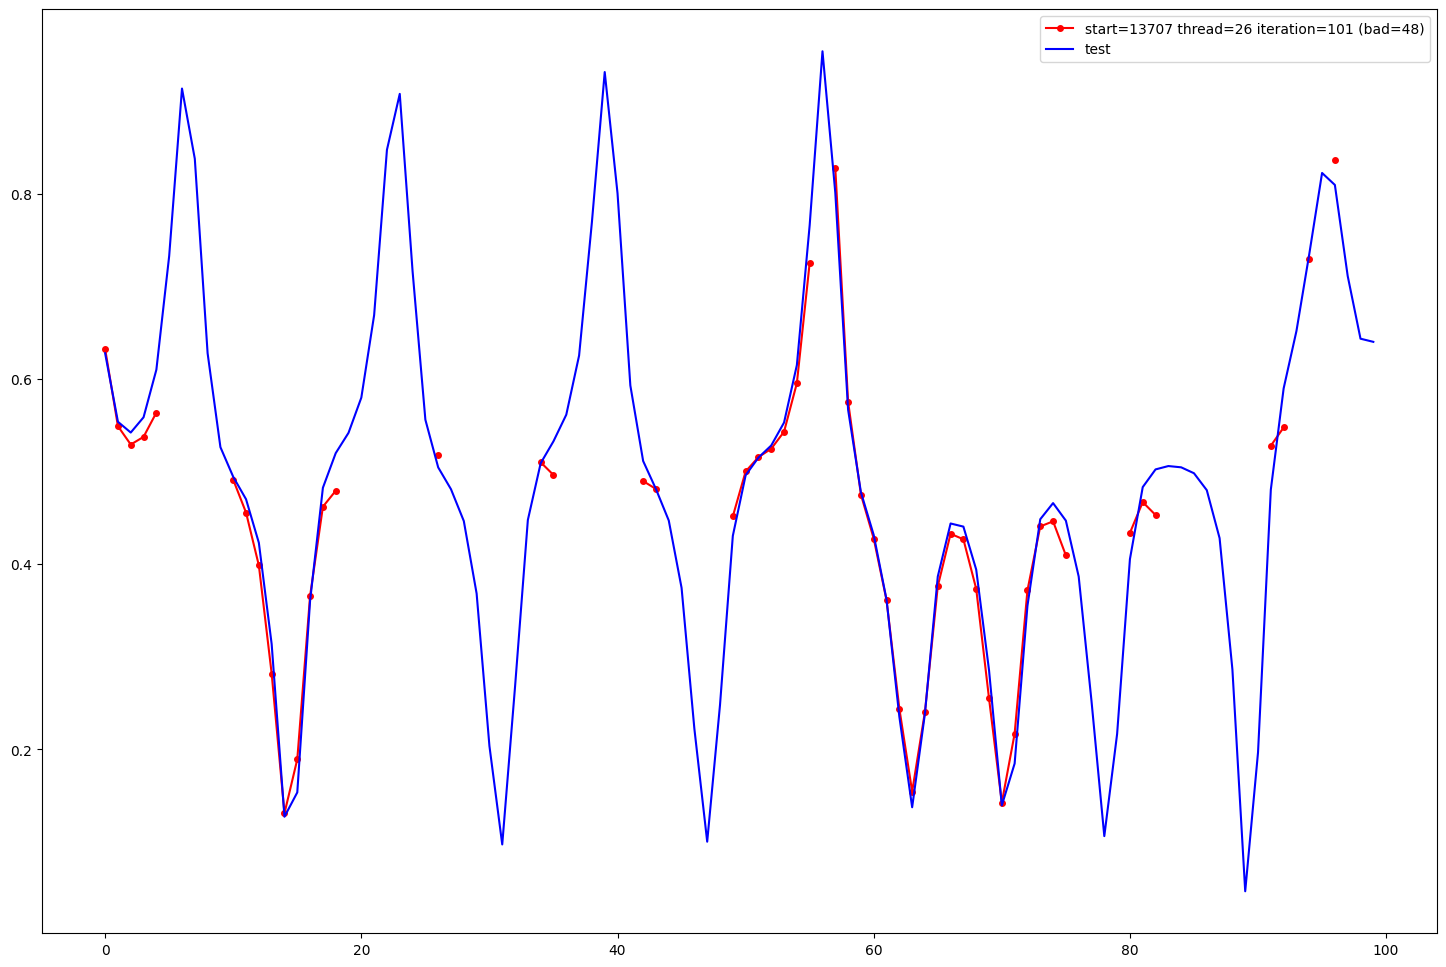

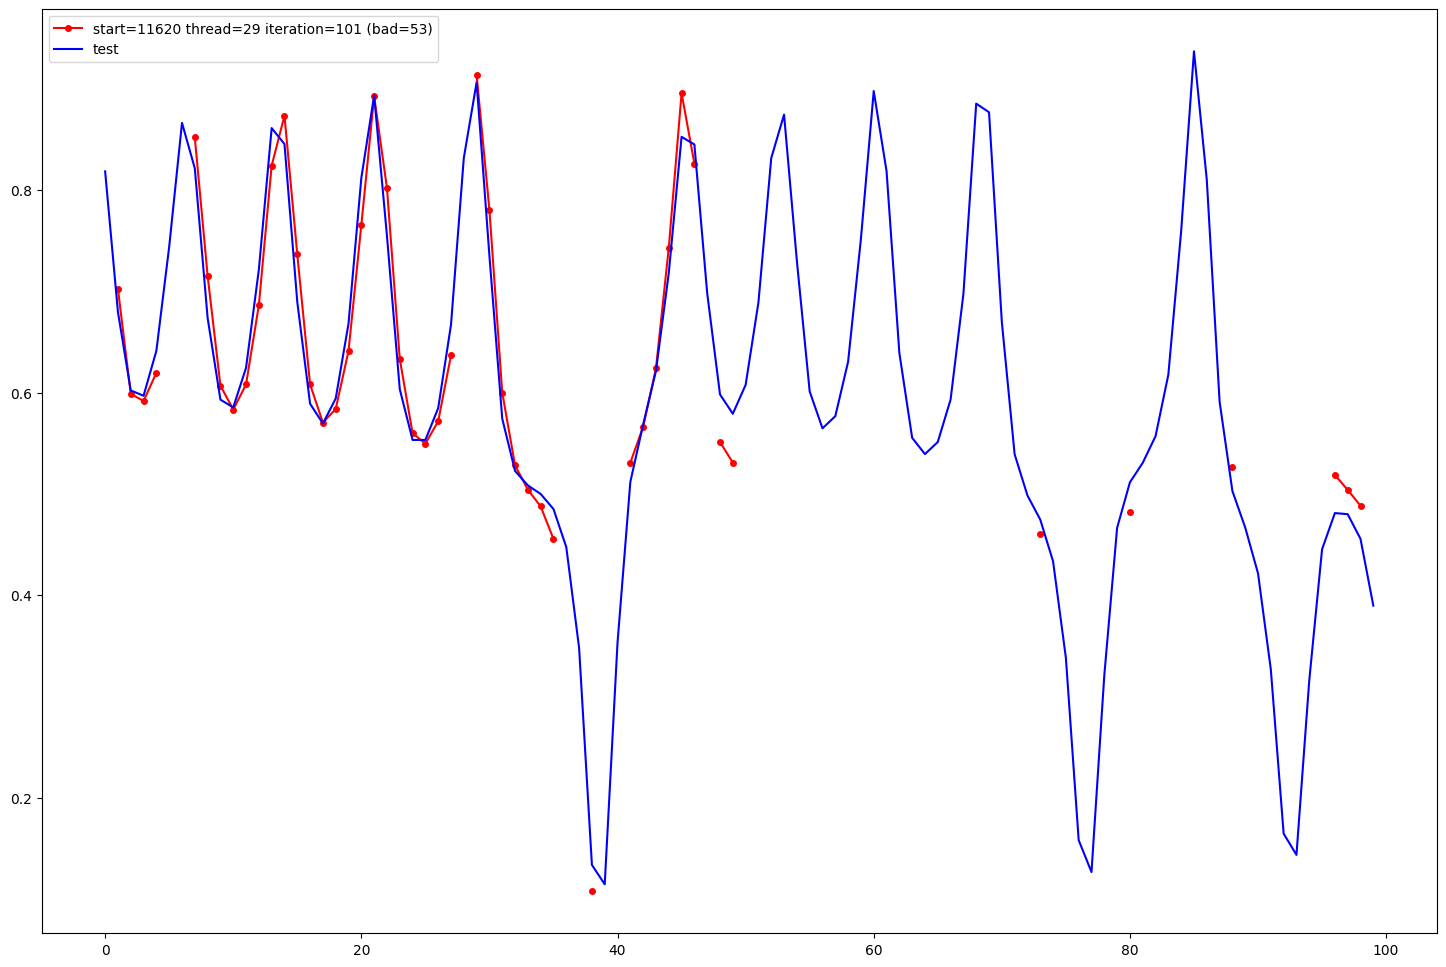

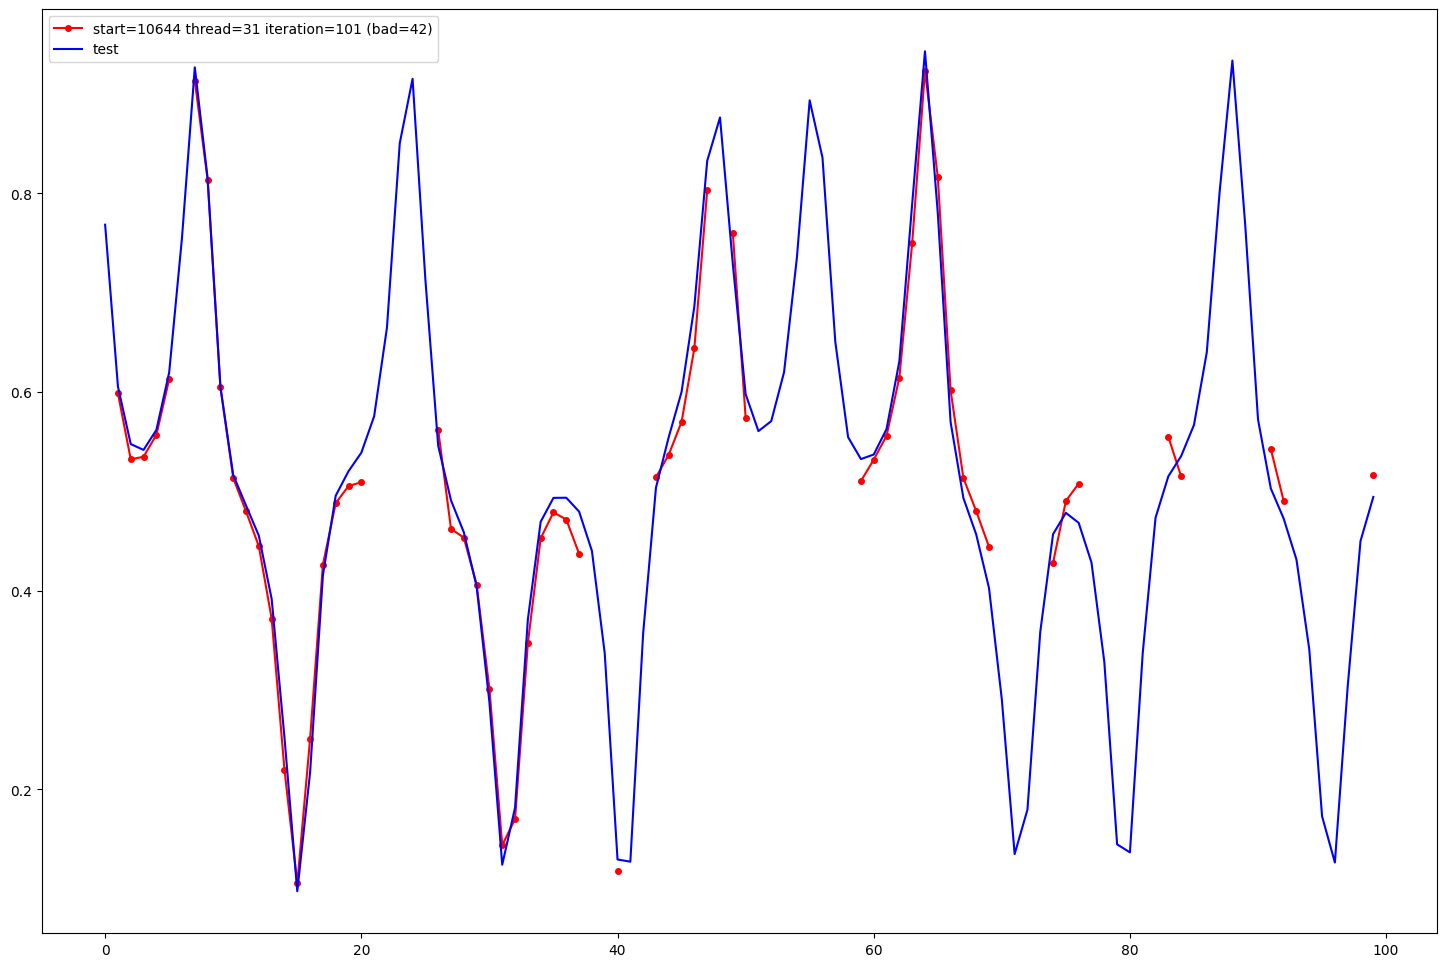

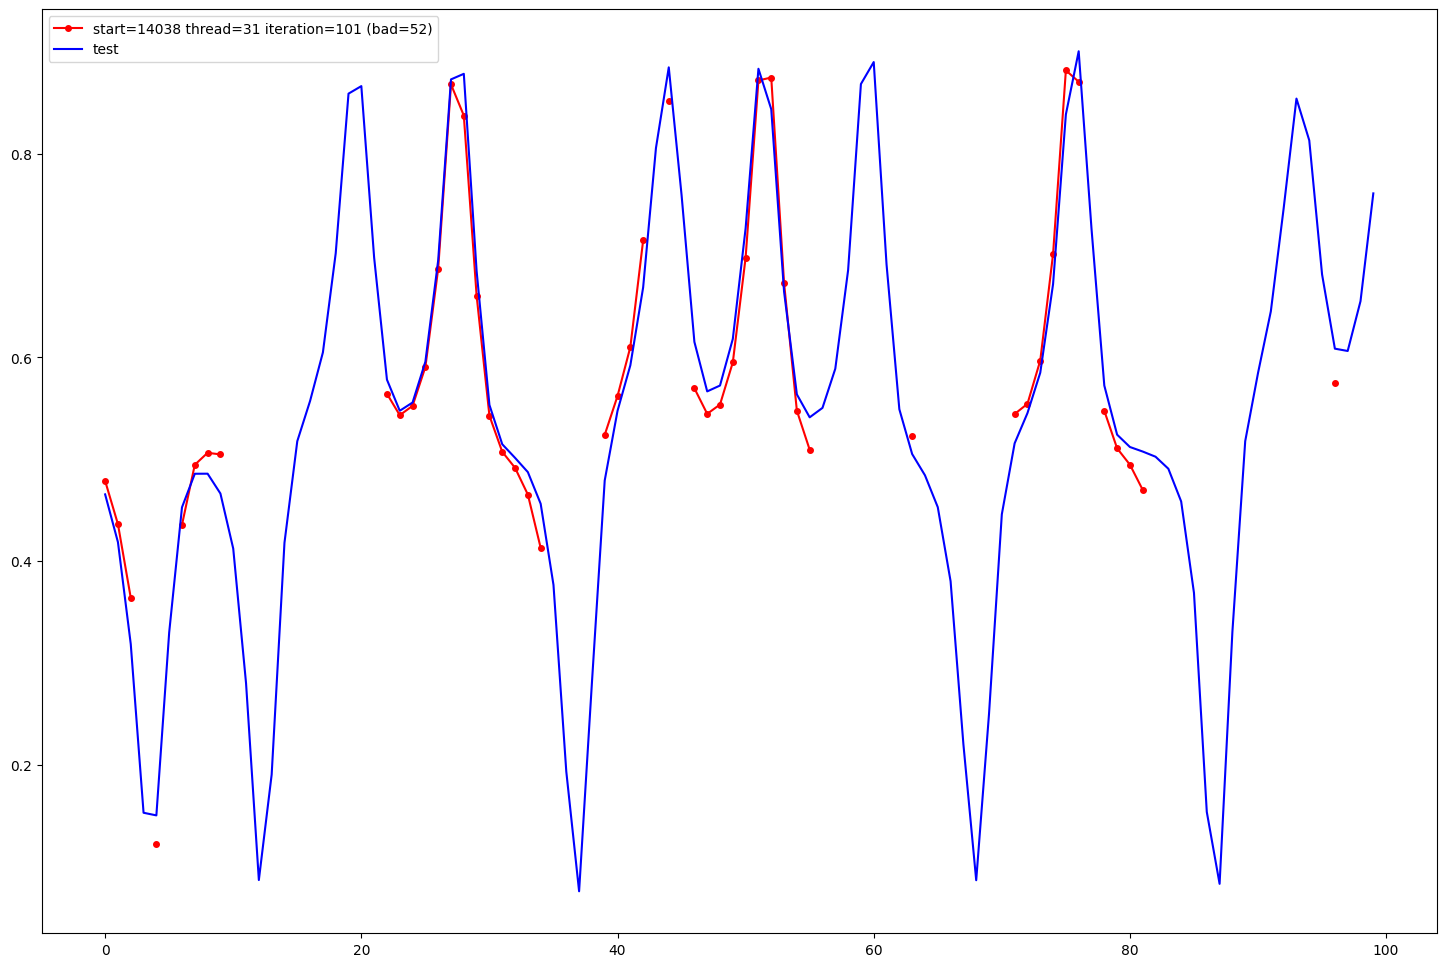

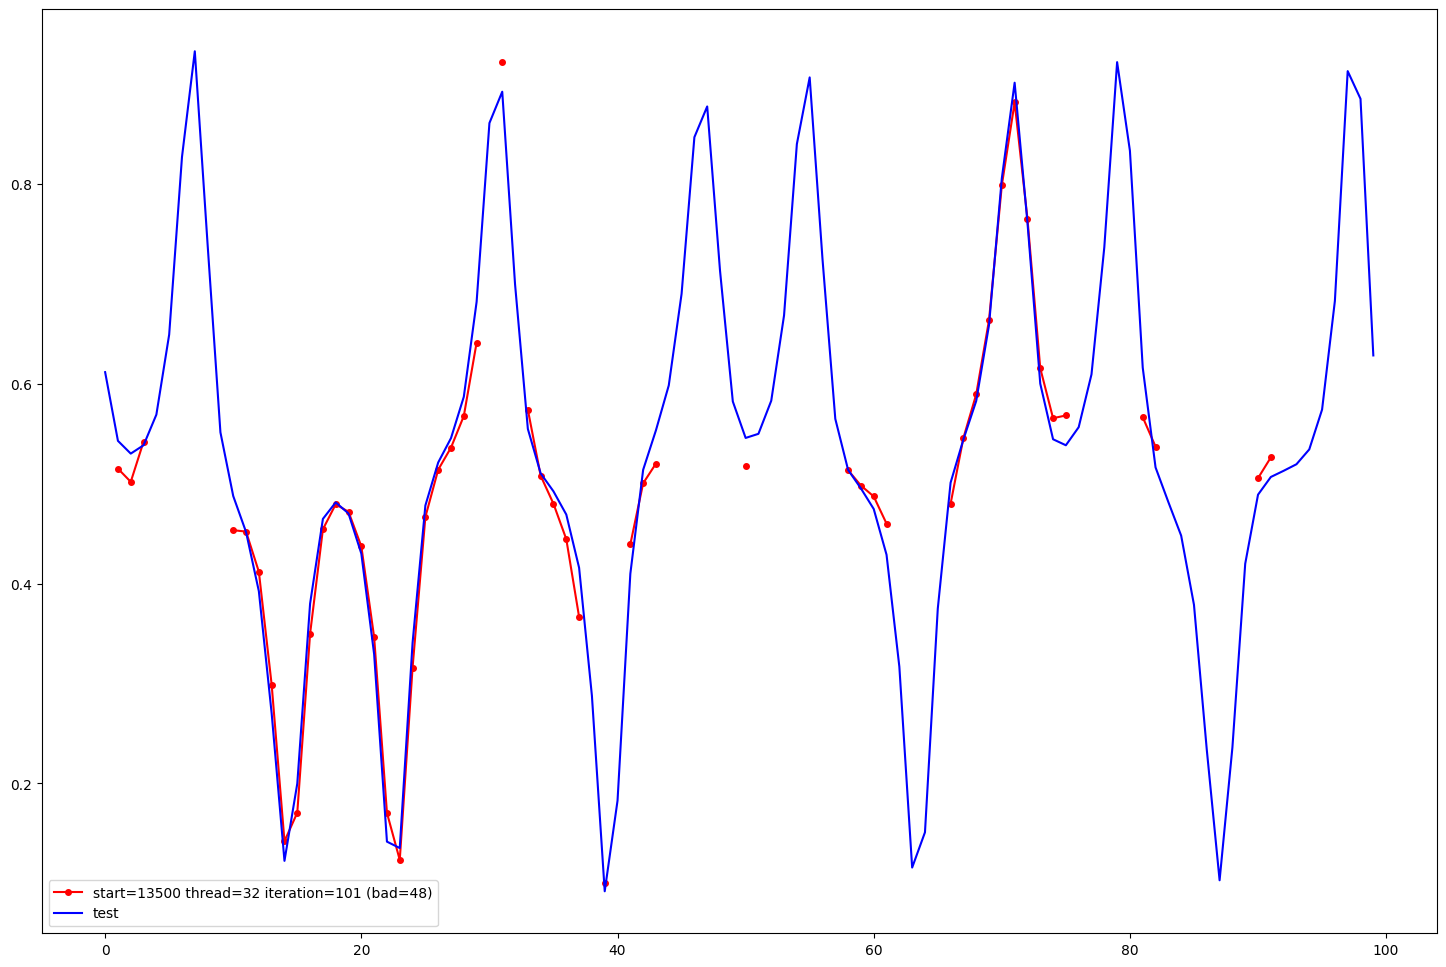

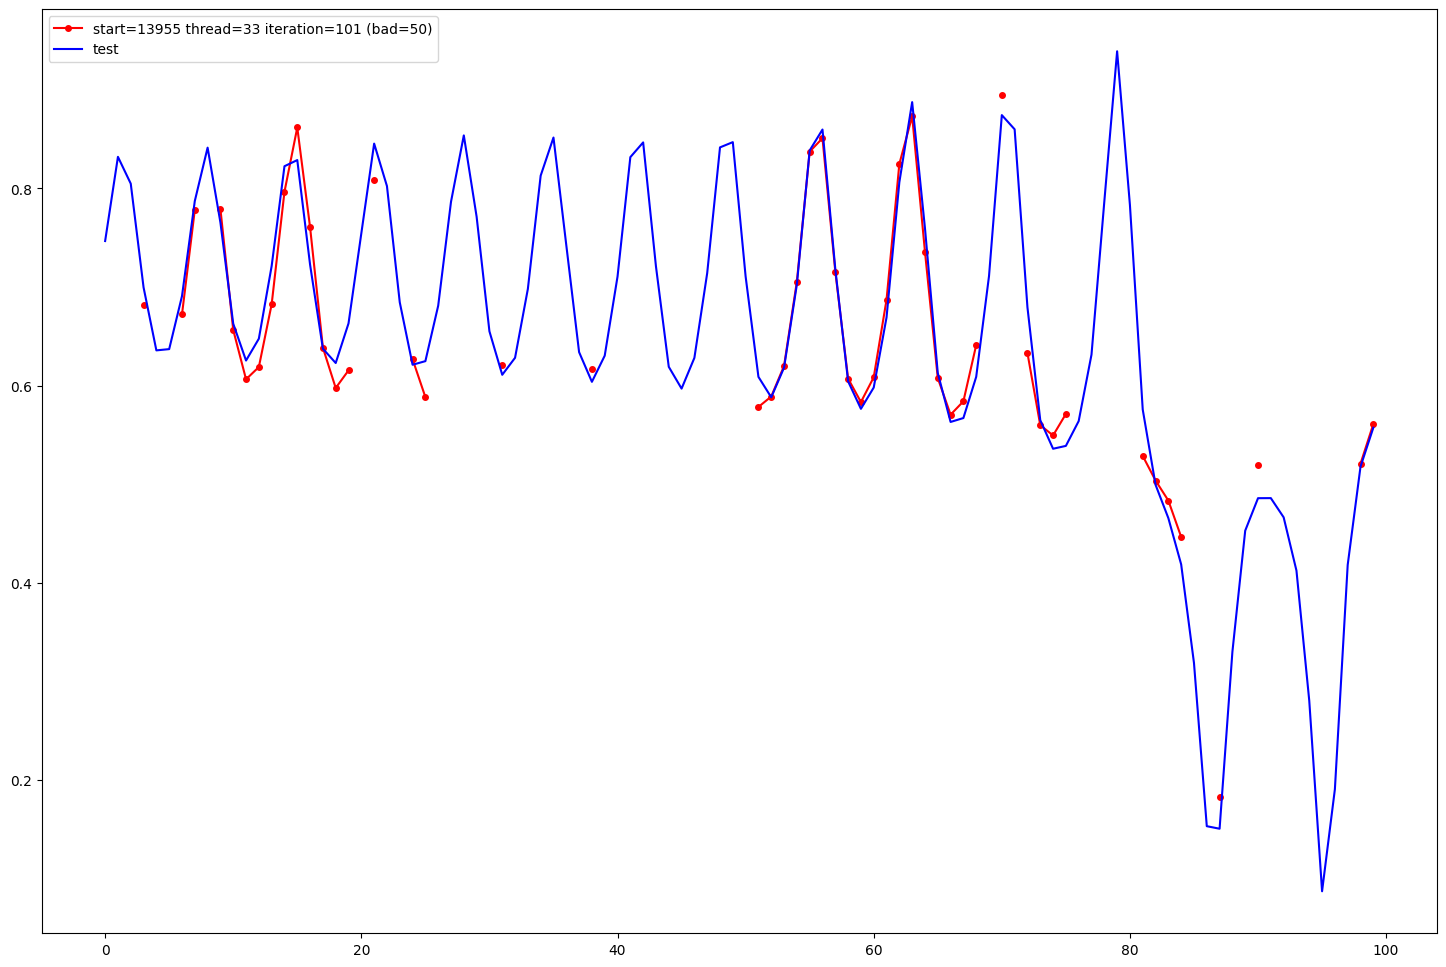

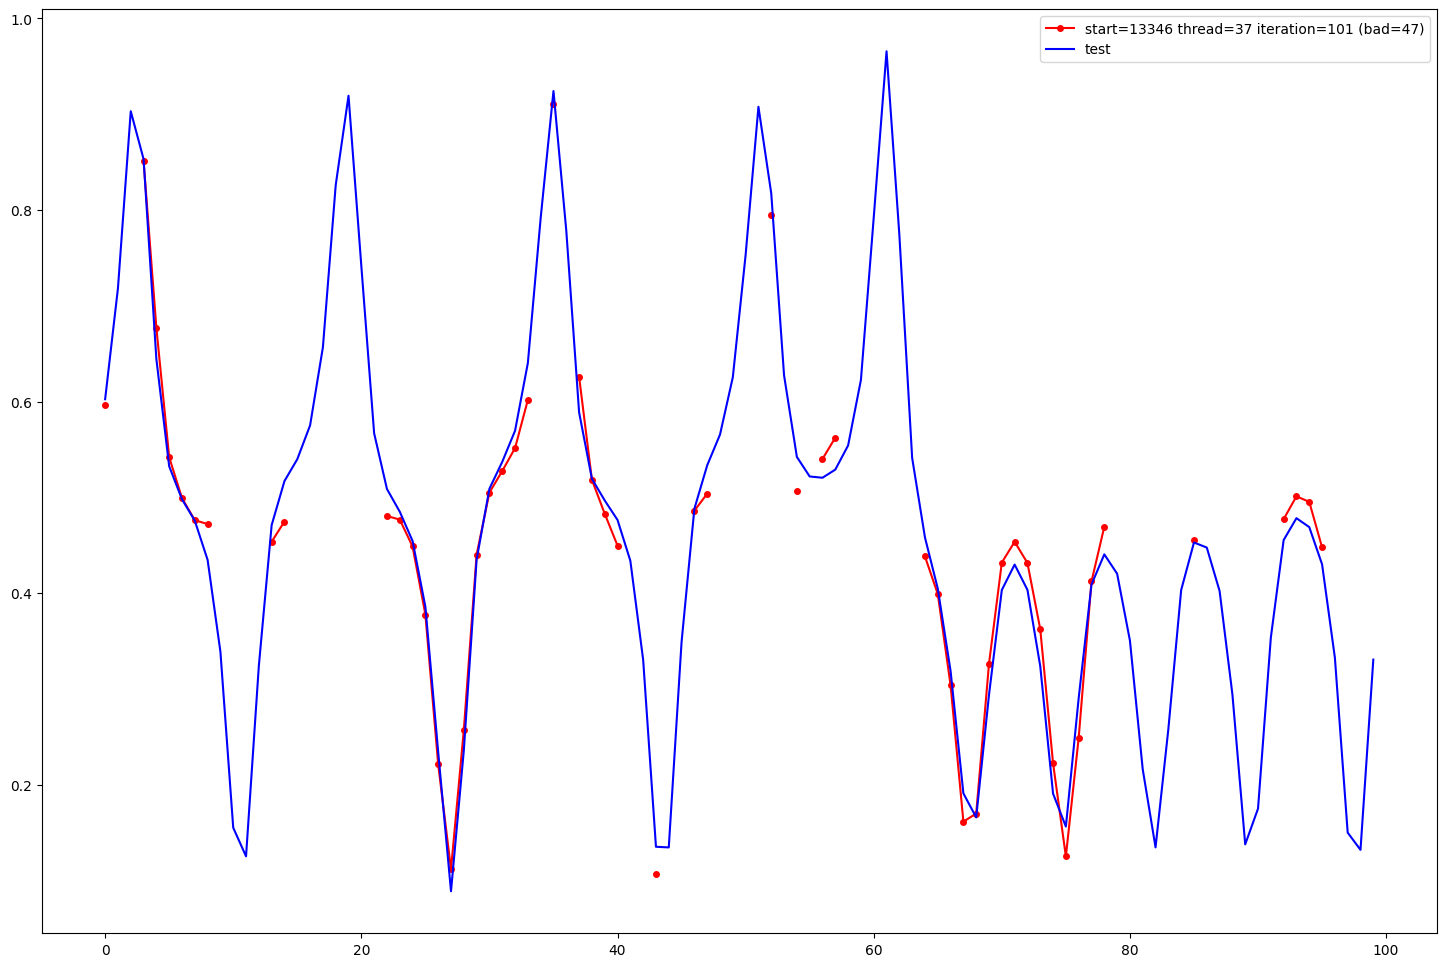

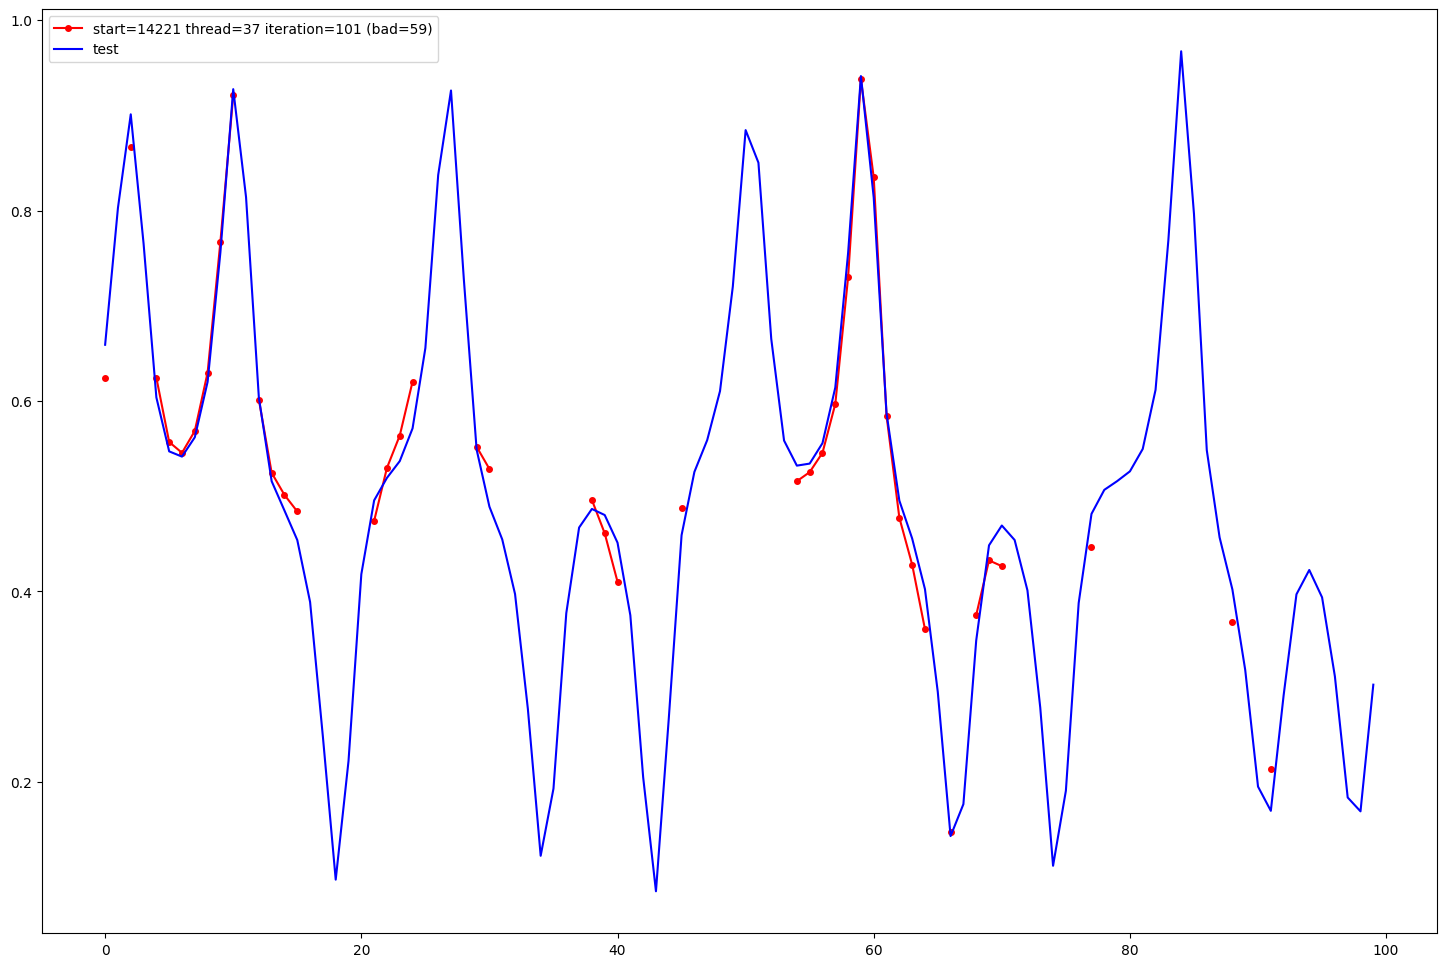

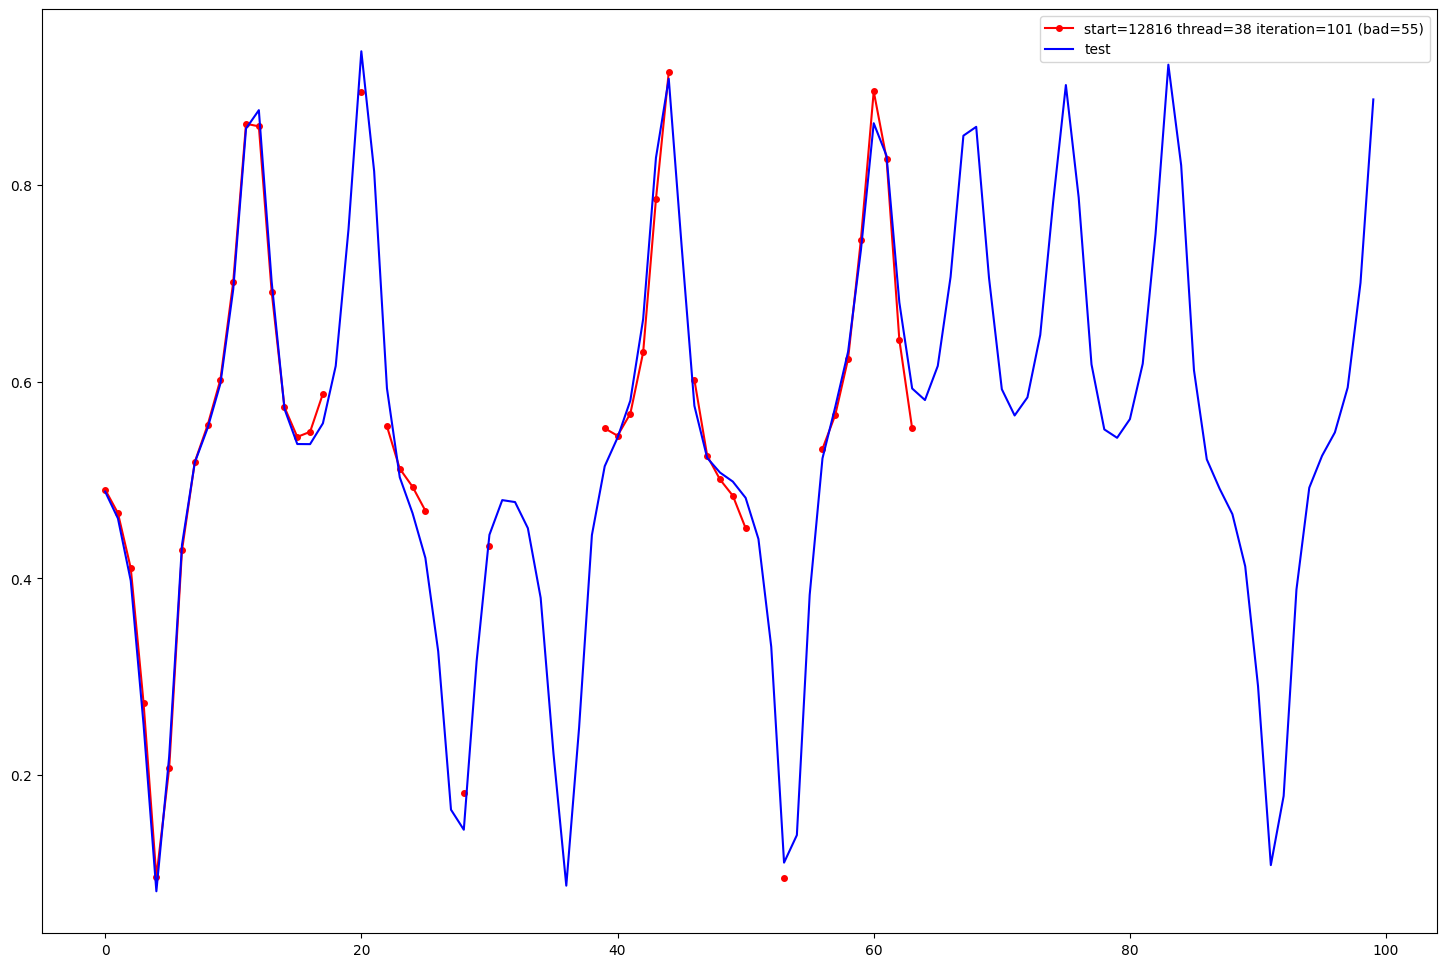

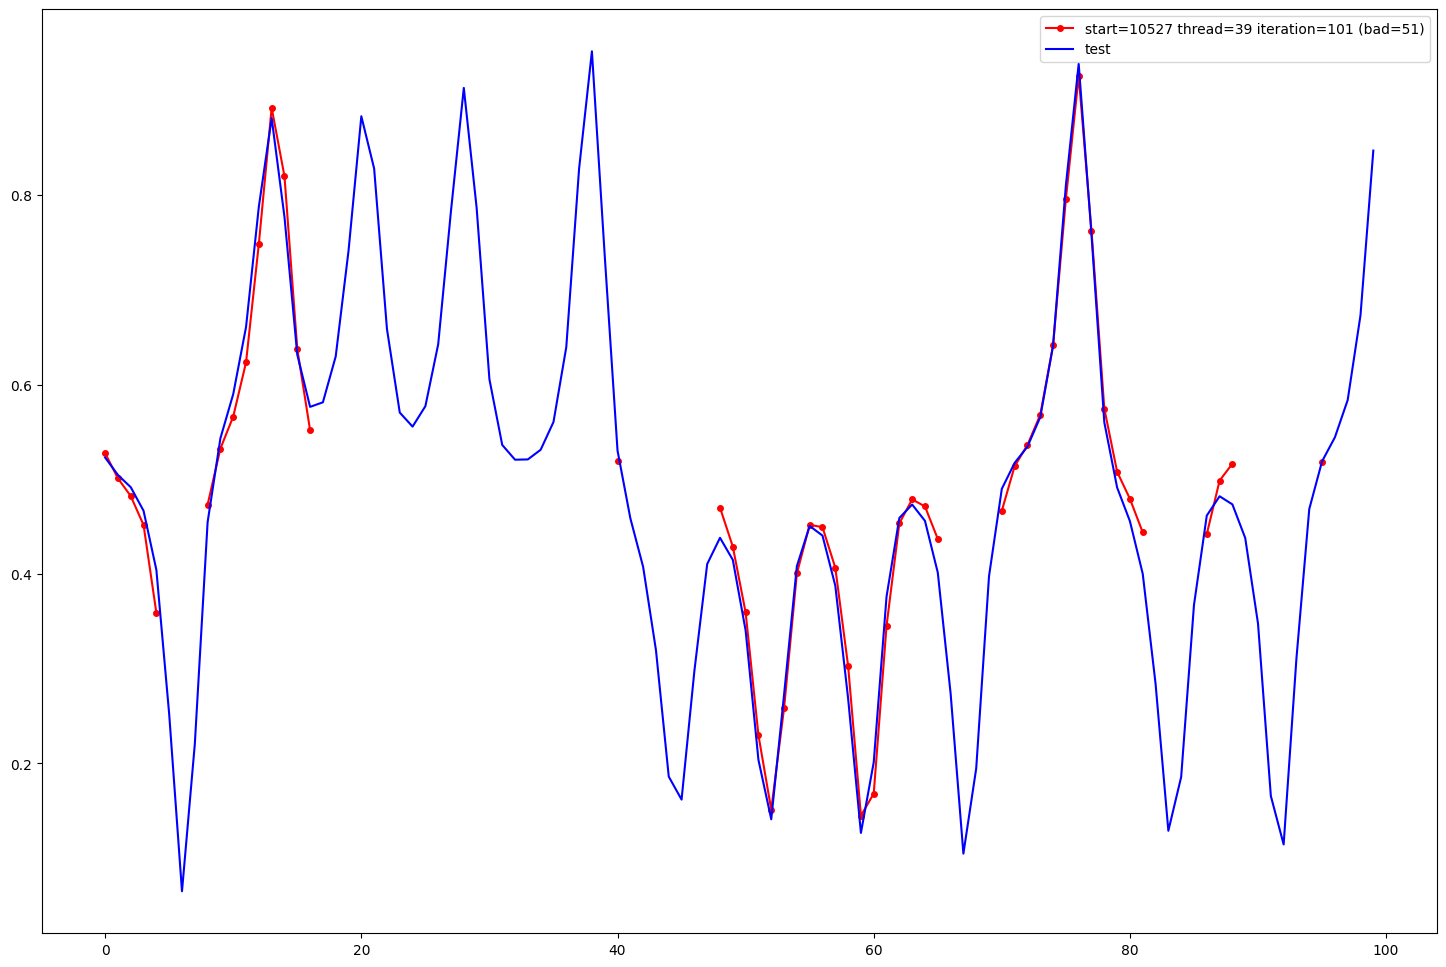

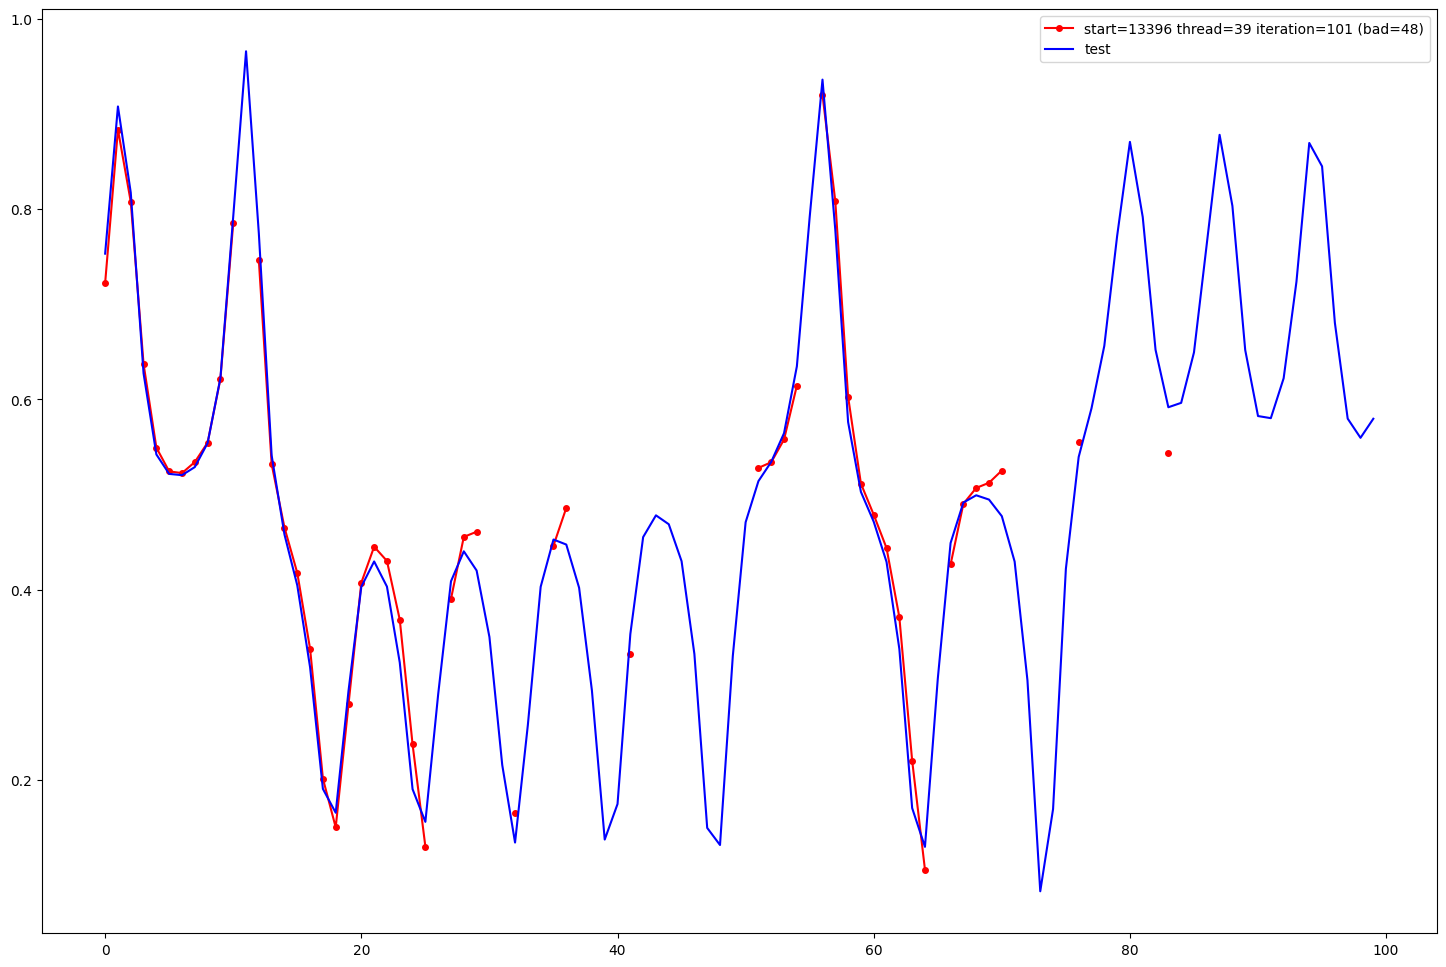

In [77]:
DIRECTORY = "final_multithread_copy"
for point, thread in start_points:
    try:
        visualize(DIRECTORY, thread, point, 101, 100, 60)
    except:
        pass